In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [2]:
# Assuming that the dataset has a column named 'junction'.
# If the column name is different (e.g., 'Junction'), adjust accordingly.
df_junction1 = df[df['Junction'] == 1].reset_index(drop=True)
print("Filtered data shape (junction 1 only):", df_junction1.shape)


Filtered data shape (junction 1 only): (14592, 4)


In [3]:
import numpy as np

# Load the indices from the saved text files
train_idx = np.loadtxt("train_order_idx.txt", dtype=int)
val_idx   = np.loadtxt("val_order_idx.txt", dtype=int)
test_idx  = np.loadtxt("test_order_idx.txt", dtype=int)

# Re-create the training, validation, and test DataFrames from df_junction1
train_data = df_junction1.iloc[train_idx].reset_index(drop=True)
val_data   = df_junction1.iloc[val_idx].reset_index(drop=True)
test_data  = df_junction1.iloc[test_idx].reset_index(drop=True)

print("Train, Val, and Test sets created:")
print(" - Train data shape:", train_data.shape)
print(" - Validation data shape:", val_data.shape)
print(" - Test data shape:", test_data.shape)


Train, Val, and Test sets created:
 - Train data shape: (10214, 4)
 - Validation data shape: (1459, 4)
 - Test data shape: (2919, 4)


In [4]:
import pandas as pd

# Convert the DateTime column to datetime, if not already done
for d in [train_data, val_data, test_data]:
    d['DateTime'] = pd.to_datetime(d['DateTime'])

# Define the target column and feature columns
target_col = 'Vehicles'
# Remove target and DateTime columns from features list
feature_cols = [col for col in train_data.columns if col not in [target_col, 'DateTime']]

# Separate features and target for each split
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# No scaling at this stage - we'll handle specific scaling later
print("Features and targets separated without scaling.")

Features and targets separated without scaling.


In [5]:
# GPU setup
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Removed StandardScaler as temp_scaler is no longer needed
from sklearn.preprocessing import QuantileTransformer
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Enhanced temporal features (Function kept for sorting and feature extraction) ===
# This function and the temporal_feature_names list might be used by LATER refinement models,
# but TimeSeriesTransformer itself will not use these features in this configuration if num_time_features=0.
def extract_enhanced_datetime_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_workday'] = (~df['is_weekend']).astype(int)
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = ((df['morning_rush'] | df['evening_rush']) & df['is_workday']).astype(int)
    return df

temporal_feature_names = [
    'hour_sin', 'hour_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos',
    'is_weekend', 'is_workday',
    'morning_rush', 'evening_rush', 'is_rush_hour',
]
temporal_feature_names.extend(['day', 'year'])


# === Preprocess data ===
context_length = 168
prediction_length = 1
lags_sequence = [1, 2, 3, 4, 5, 6, 7, 24, 48, 72, 96, 120, 144, 168]
max_lag = max(lags_sequence) if lags_sequence else 0

# Sort data by DateTime
train_data_sorted = extract_enhanced_datetime_features(train_data.sort_values('DateTime').reset_index(drop=True))
val_data_sorted = extract_enhanced_datetime_features(val_data.sort_values('DateTime').reset_index(drop=True))
test_data_sorted = extract_enhanced_datetime_features(test_data.sort_values('DateTime').reset_index(drop=True))

# --- Target Scaling (Only scale the target 'Vehicles') ---
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(train_data_sorted)))
scaler.fit(train_data_sorted['Vehicles'].values.reshape(-1, 1))

train_scaled_target = scaler.transform(train_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
val_scaled_target = scaler.transform(val_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
test_scaled_target = scaler.transform(test_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()

# --- Temporal Feature Scaling (Still perform this, as refinement models might use these features) ---
from sklearn.preprocessing import StandardScaler
temporal_scalers = {}
for feature_name in ['year', 'day']:
    if feature_name in temporal_feature_names:
        s = StandardScaler()
        train_data_sorted[feature_name] = s.fit_transform(train_data_sorted[[feature_name]]).flatten()
        val_data_sorted[feature_name] = s.transform(val_data_sorted[[feature_name]]).flatten()
        test_data_sorted[feature_name] = s.transform(test_data_sorted[[feature_name]]).flatten()
        temporal_scalers[feature_name] = s
        print(f"Scaled temporal feature: {feature_name}")

train_temporal_features_df = train_data_sorted[temporal_feature_names]
val_temporal_features_df = val_data_sorted[temporal_feature_names]
test_temporal_features_df = test_data_sorted[temporal_feature_names]


# --- Prepare Data for TimeSeriesTransformer (Modified to include dummy time features) ---
def prepare_timeseriestransformer_data(scaled_target_values,
                                         hist_len, pred_len, lags_seq):
    """
    Prepares data sequences for TimeSeriesTransformer.
    Includes dummy time features if num_time_features in config is 0.
    """
    max_l = max(lags_seq) if lags_seq else 0
    # For TimeSeriesTransformer, past_values fed to encoder is context_length + max_lag
    # The true context_length for the encoder part of TimeSeriesTransformer is hist_len (context_length from config)
    # The prepare_data function needs to provide hist_len + max_l for past_values if lags are used by the model internally from past_values.
    # The TimeSeriesTransformer model itself handles lag creation from past_values if lags_sequence is provided.
    # So, the input past_values should be of length context_length + max(lags_sequence).
    encoder_seq_len = hist_len + max_l
    past_values_list, past_observed_mask_list = [], []
    future_values_list = []
    # --- ADDED: Dummy time feature lists ---
    past_time_features_list, future_time_features_list = [], []


    # Total length of a sample needed from the original series
    total_sample_len = encoder_seq_len + pred_len

    for i in range(len(scaled_target_values) - total_sample_len + 1):
        # past_values for TimeSeriesTransformer should be [batch_size, context_length + max(config.lags_sequence)]
        past_vals_slice = scaled_target_values[i : i + encoder_seq_len]
        past_values_list.append(past_vals_slice)

        past_observed_mask_list.append(np.ones(encoder_seq_len, dtype=bool))

        # future_values for TimeSeriesTransformer is [batch_size, prediction_length]
        future_vals_slice = scaled_target_values[i + encoder_seq_len : i + total_sample_len]
        future_values_list.append(future_vals_slice)

        # --- ADDED: Create dummy time features (shape: seq_len, 0) ---
        # past_time_features: [batch_size, context_length + max(lags_sequence), num_time_features]
        past_time_features_list.append(np.zeros((encoder_seq_len, 0), dtype=np.float32))
        # future_time_features: [batch_size, prediction_length, num_time_features]
        future_time_features_list.append(np.zeros((pred_len, 0), dtype=np.float32))


    return (
        np.array(past_values_list),
        np.array(past_observed_mask_list),
        np.array(future_values_list),
        # --- ADDED: Return dummy time features ---
        np.array(past_time_features_list),
        np.array(future_time_features_list)
    )

# TimeSeriesTransformer does not use a 'label_length' config parameter in the same way Autoformer does.
# The teacher-forcing mechanism is standard.

# --- MODIFIED CALLS to prepare_timeseriestransformer_data ---
train_past_vals, train_mask, train_future_vals, train_past_time_dummy, train_future_time_dummy = prepare_timeseriestransformer_data(
    train_scaled_target, context_length, prediction_length, lags_sequence
)
val_past_vals, val_mask, val_future_vals, val_past_time_dummy, val_future_time_dummy = prepare_timeseriestransformer_data(
    val_scaled_target, context_length, prediction_length, lags_sequence
)
test_past_vals, test_mask, test_future_vals, test_past_time_dummy, test_future_time_dummy = prepare_timeseriestransformer_data(
    test_scaled_target, context_length, prediction_length, lags_sequence
)

# Create tensors for TimeSeriesTransformer
train_past_values_tensor = torch.tensor(train_past_vals, dtype=torch.float32).to(device)
train_observed_mask_tensor = torch.tensor(train_mask, dtype=torch.bool).to(device)
train_future_values_tensor = torch.tensor(train_future_vals, dtype=torch.float32).to(device)
# --- ADDED: Tensors for dummy time features ---
train_past_time_features_tensor = torch.tensor(train_past_time_dummy, dtype=torch.float32).to(device)
train_future_time_features_tensor = torch.tensor(train_future_time_dummy, dtype=torch.float32).to(device)


val_past_values_tensor = torch.tensor(val_past_vals, dtype=torch.float32).to(device)
val_observed_mask_tensor = torch.tensor(val_mask, dtype=torch.bool).to(device)
val_future_values_tensor = torch.tensor(val_future_vals, dtype=torch.float32).to(device)
# --- ADDED: Tensors for dummy time features ---
val_past_time_features_tensor = torch.tensor(val_past_time_dummy, dtype=torch.float32).to(device)
val_future_time_features_tensor = torch.tensor(val_future_time_dummy, dtype=torch.float32).to(device)


test_past_values_tensor = torch.tensor(test_past_vals, dtype=torch.float32).to(device)
test_observed_mask_tensor = torch.tensor(test_mask, dtype=torch.bool).to(device)
test_future_values_tensor = torch.tensor(test_future_vals, dtype=torch.float32).to(device)
# --- ADDED: Tensors for dummy time features ---
test_past_time_features_tensor = torch.tensor(test_past_time_dummy, dtype=torch.float32).to(device)
test_future_time_features_tensor = torch.tensor(test_future_time_dummy, dtype=torch.float32).to(device)


# Create dataset and dataloader (MODIFIED)
train_dataset = TensorDataset(
    train_past_values_tensor,
    train_observed_mask_tensor,
    train_future_values_tensor,
    # --- ADDED: Dummy time feature tensors to dataset ---
    train_past_time_features_tensor,
    train_future_time_features_tensor
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# === TimeSeriesTransformer Config (MODIFIED) ===
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=1, # Univariate input 'Vehicles'
    lags_sequence=lags_sequence,
    # --- CRITICAL CHANGE: No time features for TimeSeriesTransformer model itself if num_time_features=0 ---
    num_time_features=0, # This remains 0 as we are passing dummy time features of shape (seq_len, 0)
    num_dynamic_real_features=0, # No other dynamic real features
    num_static_categorical_features=0, # No static categorical features
    num_static_real_features=0, # No static real features

    distribution_output="student_t",
    loss="nll",

    d_model=64,
    encoder_layers=2,
    decoder_layers=2,
    encoder_attention_heads=2,
    decoder_attention_heads=2,
    encoder_ffn_dim=128,
    decoder_ffn_dim=128,
    dropout=0.1,

    # Parameters like label_length, moving_average, autocorrelation_factor are Autoformer-specific and removed.
    scaling=None, # Explicitly set to None, as Autoformer had this. Default for TST is 'mean'.

    num_parallel_samples=100 # For generation
)

model = TimeSeriesTransformerForPrediction(config).to(device)

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# === Training (MODIFIED model call) ===
print("Starting TimeSeriesTransformer training (with dummy temporal features)...")
best_val_loss = float('inf')
patience = 15
patience_counter = 0
epochs = 50
train_losses, val_losses, epoch_times = [], [], []
model_name = "TimeSeriesTransformer_no_temp_model"

for epoch in range(epochs):
    model.train()
    epoch_start = time.time()
    epoch_loss = 0

    # --- MODIFIED: Unpack batch to include dummy time features ---
    for batch_past_vals, batch_mask, batch_future_vals, batch_past_time, batch_future_time in train_loader:
        optimizer.zero_grad()

        # --- MODIFIED: Call model WITH dummy time features ---
        # For TimeSeriesTransformer, future_observed_mask can be added if needed, defaults to all observed.
        outputs = model(
            past_values=batch_past_vals,
            past_observed_mask=batch_mask,
            past_time_features=batch_past_time,    # Pass dummy past time features
            future_values=batch_future_vals,
            future_time_features=batch_future_time    # Pass dummy future time features
        )

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item() * batch_past_vals.size(0)

    avg_train_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Validation (MODIFIED model call)
    model.eval()
    with torch.no_grad():
        # --- MODIFIED: Call model WITH dummy time features ---
        val_outputs = model(
            past_values=val_past_values_tensor,
            past_observed_mask=val_observed_mask_tensor,
            past_time_features=val_past_time_features_tensor,    # Pass dummy past time features
            future_values=val_future_values_tensor,
            future_time_features=val_future_time_features_tensor    # Pass dummy future time features
        )
        val_loss = val_outputs.loss.item()
        val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained(model_name)
        print(f"  -> Validation loss improved to {best_val_loss:.6f}. Saving model.")
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f} - Time: {epoch_time:.2f}s")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# === Summary ===
print(f"\nTraining completed in {len(train_losses)} epochs")
if val_losses: # Check if validation was performed
    best_epoch_idx = val_losses.index(min(val_losses))
    print(f"Best validation loss: {min(val_losses):.6f} at epoch {best_epoch_idx + 1}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")
else:
    print("No validation losses recorded.")


# === Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
if val_losses: # Only plot validation if it exists
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='s')
    # Ensure best_epoch_idx is defined before using it
    if 'best_epoch_idx' in locals():
        plt.scatter(best_epoch_idx + 1, min(val_losses), c='red', s=100, label='Best Epoch', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TimeSeriesTransformer Training History (Lag Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Load the best model for evaluation
print(f"\nLoading best model from {model_name} for evaluation...")
# Check if the model was saved before trying to load
import os
if os.path.exists(model_name):
    model = TimeSeriesTransformerForPrediction.from_pretrained(model_name).to(device)
    print("Best model loaded successfully.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch.")
    # Keep the 'model' variable as it is (from the end of training)

KeyboardInterrupt: 

Loaded best model from TimeSeriesTransformer_no_temp_model for evaluation.
Generating predictions on the test set using model.generate()...
Shape of scaled predictions: (2583,)
Shape of original predictions: (2583,)
Shape of original targets: (2583,)

TimeSeriesTransformer Test RMSE: 10.88
TimeSeriesTransformer Test MAE: 6.88


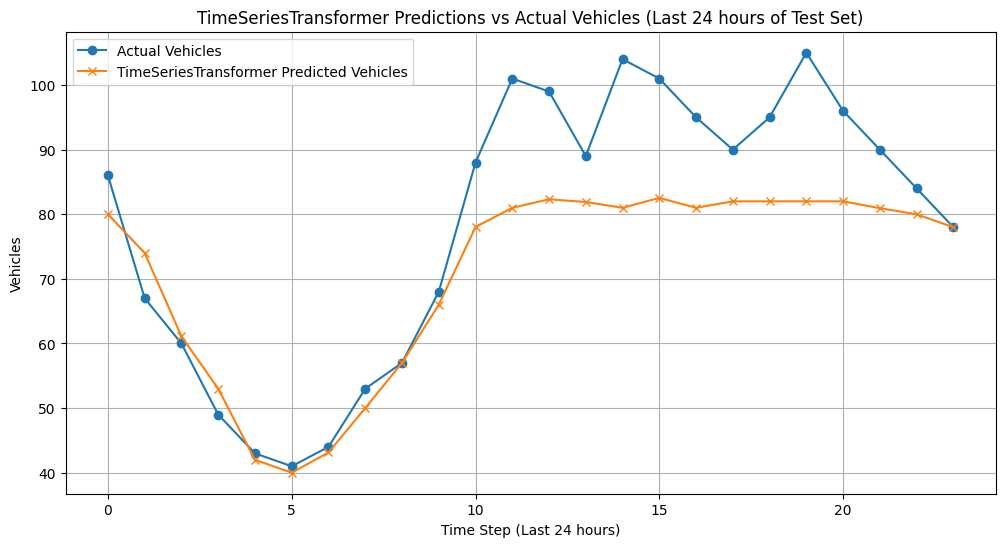

In [ ]:
# === Evaluate TimeSeriesTransformer Model ===
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

# Ensure the best model is loaded (or use the last trained one if save failed)
# model_name should be defined in the previous cell (e.g., "TimeSeriesTransformer_no_temp_model")
if os.path.exists(model_name):
    # --- MODIFIED MODEL LOADING ---
    model = TimeSeriesTransformerForPrediction.from_pretrained(model_name).to(device)
    print(f"Loaded best model from {model_name} for evaluation.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch for evaluation.")
    model.to(device) # Ensure model from training is on correct device

model.eval()
all_preds_scaled = []

# For TimeSeriesTransformer's generate method, we need future_time_features for the prediction window.
# These were already prepared as test_future_time_features_tensor.

# Create a DataLoader for evaluation if the test set is large
# The test_dataset should provide all necessary inputs for model.generate()
# model.generate expects: past_values, past_time_features, past_observed_mask, future_time_features
# (and optionally static_categorical_features, static_real_features)
eval_test_dataset = TensorDataset(
    test_past_values_tensor,
    test_past_time_features_tensor,
    test_observed_mask_tensor,
    test_future_time_features_tensor # These are for the prediction horizon
)
# Reduced batch size for generate, can be GPU memory sensitive
eval_test_loader = DataLoader(eval_test_dataset, batch_size=32, shuffle=False)

print("Generating predictions on the test set using model.generate()...")
with torch.no_grad():
    for batch_past_vals, batch_past_time, batch_mask, batch_future_time_pred_window in eval_test_loader:
        # --- USE model.generate() ---
        outputs = model.generate(
            past_values=batch_past_vals,
            past_time_features=batch_past_time,
            past_observed_mask=batch_mask,
            future_time_features=batch_future_time_pred_window # Time features for the window to be predicted
            # static_categorical_features=None, # If we had them
            # static_real_features=None,     # If we had them
        )
        # outputs.sequences has shape (batch_size, num_parallel_samples, prediction_length, input_size)
        # We take the mean over num_parallel_samples (dim 1)
        # Assuming input_size=1 and prediction_length=1 for this problem
        # Squeeze to remove dimensions of size 1.
        preds = outputs.sequences.mean(dim=1).squeeze().cpu().numpy()


        # Handle cases where batch size is 1 and squeeze might remove all dims
        if preds.ndim == 0:
            preds = np.array([preds.item()])
        elif preds.ndim > 1: # If prediction_length > 1, preds might be [batch, pred_len]
            preds = preds.reshape(batch_past_vals.size(0), -1) # Flatten if necessary, or handle multi-step

        all_preds_scaled.append(preds)

timeseriestransformer_test_pred_scaled = np.concatenate(all_preds_scaled)

if timeseriestransformer_test_pred_scaled.ndim > 1 and timeseriestransformer_test_pred_scaled.shape[1] == 1:
    timeseriestransformer_test_pred_scaled = timeseriestransformer_test_pred_scaled.flatten()
# ... (rest of the prediction handling, inverse transform, metrics, plotting)
# Ensure variable names are updated e.g. timeseriestransformer_test_pred_scaled
# And y_test_orig should be derived from test_future_vals (the actual future values)
# The test_future_vals created in the previous cell are the ground truth for the scaled predictions.

print(f"Shape of scaled predictions: {timeseriestransformer_test_pred_scaled.shape}")

# Inverse transform the predictions
timeseriestransformer_test_pred_orig = scaler.inverse_transform(timeseriestransformer_test_pred_scaled.reshape(-1, 1)).flatten()
timeseriestransformer_test_pred_orig = np.clip(timeseriestransformer_test_pred_orig, 0, None)

# Get the original actual test targets corresponding to the predictions
# test_future_vals are the scaled targets for the prediction window
y_test_orig = scaler.inverse_transform(test_future_vals.reshape(-1, 1)).flatten() # test_future_vals from data prep
y_test_orig = np.clip(y_test_orig, 0, None)

print(f"Shape of original predictions: {timeseriestransformer_test_pred_orig.shape}")
print(f"Shape of original targets: {y_test_orig.shape}")

min_len = min(len(timeseriestransformer_test_pred_orig), len(y_test_orig))
if len(timeseriestransformer_test_pred_orig) != len(y_test_orig):
    print(f"Warning: Mismatch in prediction ({len(timeseriestransformer_test_pred_orig)}) and target ({len(y_test_orig)}) lengths. Trimming to {min_len}.")
timeseriestransformer_test_pred_orig = timeseriestransformer_test_pred_orig[:min_len]
y_test_orig = y_test_orig[:min_len]

if min_len > 0:
    timeseriestransformer_rmse = np.sqrt(mean_squared_error(y_test_orig, timeseriestransformer_test_pred_orig))
    timeseriestransformer_mae = mean_absolute_error(y_test_orig, timeseriestransformer_test_pred_orig)

    print(f"\nTimeSeriesTransformer Test RMSE: {timeseriestransformer_rmse:.2f}")
    print(f"TimeSeriesTransformer Test MAE: {timeseriestransformer_mae:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig[-24:], label='Actual Vehicles', marker='o')
    plt.plot(timeseriestransformer_test_pred_orig[-24:], label='TimeSeriesTransformer Predicted Vehicles', marker='x')
    plt.title('TimeSeriesTransformer Predictions vs Actual Vehicles (Last 24 hours of Test Set)')
    plt.xlabel('Time Step (Last 24 hours)')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nCannot calculate metrics or plot: No matching predictions and targets found after alignment.")
    timeseriestransformer_rmse, timeseriestransformer_mae = float('inf'), float('inf') # Define for later cells

In [ ]:
# === Generate TimeSeriesTransformer Predictions for Train/Val (Needed for Refinement) ===
print("Generating TimeSeriesTransformer predictions for Train and Validation sets...")

model.eval() # Ensure model is in eval mode

# --- Generate Train Predictions ---
all_train_preds_scaled = []
# Create DataLoader for train set evaluation
eval_train_dataset = TensorDataset(
    train_past_values_tensor,
    train_past_time_features_tensor,
    train_observed_mask_tensor,
    train_future_time_features_tensor # For prediction window
)
eval_train_loader = DataLoader(eval_train_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    for batch_past_vals, batch_past_time, batch_mask, batch_future_time_pred_window in eval_train_loader:
        outputs = model.generate(
            past_values=batch_past_vals,
            past_time_features=batch_past_time,
            past_observed_mask=batch_mask,
            future_time_features=batch_future_time_pred_window
        )
        preds = outputs.sequences.mean(dim=1).squeeze().cpu().numpy()
        if preds.ndim == 0: preds = np.array([preds.item()])
        elif preds.ndim > 1: preds = preds.reshape(batch_past_vals.size(0), -1)
        all_train_preds_scaled.append(preds)
timeseriestransformer_train_pred_scaled = np.concatenate(all_train_preds_scaled)
if timeseriestransformer_train_pred_scaled.ndim != 1:
    timeseriestransformer_train_pred_scaled = timeseriestransformer_train_pred_scaled.flatten()

# --- Generate Validation Predictions ---
all_val_preds_scaled = []
eval_val_dataset = TensorDataset(
    val_past_values_tensor,
    val_past_time_features_tensor,
    val_observed_mask_tensor,
    val_future_time_features_tensor # For prediction window
)
eval_val_loader = DataLoader(eval_val_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    for batch_past_vals, batch_past_time, batch_mask, batch_future_time_pred_window in eval_val_loader:
        outputs = model.generate(
            past_values=batch_past_vals,
            past_time_features=batch_past_time,
            past_observed_mask=batch_mask,
            future_time_features=batch_future_time_pred_window
        )
        preds = outputs.sequences.mean(dim=1).squeeze().cpu().numpy()
        if preds.ndim == 0: preds = np.array([preds.item()])
        elif preds.ndim > 1: preds = preds.reshape(batch_past_vals.size(0), -1)
        all_val_preds_scaled.append(preds)
timeseriestransformer_val_pred_scaled = np.concatenate(all_val_preds_scaled)
if timeseriestransformer_val_pred_scaled.ndim != 1:
    timeseriestransformer_val_pred_scaled = timeseriestransformer_val_pred_scaled.flatten()

print(f"TimeSeriesTransformer Train Pred Scaled Shape: {timeseriestransformer_train_pred_scaled.shape}")
print(f"TimeSeriesTransformer Val Pred Scaled Shape: {timeseriestransformer_val_pred_scaled.shape}")
# timeseriestransformer_test_pred_scaled should exist from the previous cell

# --- Temporal Features List (ensure temporal_feature_names is defined) ---
# temporal_feature_names should be defined from cell fa036375

# --- Align Temporal Features and Targets ---
# The prepare_timeseriestransformer_data function creates sequences.
# The number of sequences is len(original_data) - (encoder_seq_len + prediction_length - 1).
# encoder_seq_len for prepare_timeseriestransformer_data was context_length + max(lags_sequence)
# The temporal features and targets need to align with the *output* of these sequences.
# The output corresponds to the `future_values` part.
# The `train_future_vals`, `val_future_vals`, `test_future_vals` from data prep are the scaled targets.

y_train_scaled_aligned = train_future_vals.flatten()
y_val_scaled_aligned = val_future_vals.flatten()
y_test_scaled_aligned = test_future_vals.flatten()


# Temporal features for refinement model should correspond to the time step *being predicted*.
# The TimeSeriesTransformer model produces `num_train_samples` sequences.
# The i-th sequence's prediction corresponds to the original data point at index `i + timeseriestransformer_input_seq_len` (start of future_values).
# We need to extract temporal features from `train_temporal_features_df`
# that align with these prediction points.

# These variables are defined in cell fa036375:
# train_temporal_features_df, val_temporal_features_df, test_temporal_features_df
# context_length, lags_sequence, prediction_length
# train_future_vals, val_future_vals, test_future_vals

# Calculate input sequence length consistent with prepare_timeseriestransformer_data
current_max_lag = max(lags_sequence) if lags_sequence else 0
timeseriestransformer_input_seq_len = context_length + current_max_lag # This is the length of past_values fed to the model

# Number of samples produced by TimeSeriesTransformer data preparation
num_train_samples = len(train_future_vals)
num_val_samples = len(val_future_vals)
num_test_samples = len(test_future_vals) # or len(timeseriestransformer_test_pred_scaled)

if prediction_length == 1:
    # Slice the original temporal features DataFrames to align with TimeSeriesTransformer outputs
    # The first predicted point of the TimeSeriesTransformer output corresponds to the (timeseriestransformer_input_seq_len)-th
    # point in the original sorted data (0-indexed), which is the start of the first future_value.
    train_temporal = train_temporal_features_df.iloc[timeseriestransformer_input_seq_len : timeseriestransformer_input_seq_len + num_train_samples].values
    val_temporal = val_temporal_features_df.iloc[timeseriestransformer_input_seq_len : timeseriestransformer_input_seq_len + num_val_samples].values
    test_temporal = test_temporal_features_df.iloc[timeseriestransformer_input_seq_len : timeseriestransformer_input_seq_len + num_test_samples].values
else:
    # If prediction_length > 1, this refinement setup uses features for the first predicted step.
    print(f"Warning: prediction_length is {prediction_length}. Using temporal features of the first future step for refinement.")
    train_temporal = train_temporal_features_df.iloc[timeseriestransformer_input_seq_len : timeseriestransformer_input_seq_len + num_train_samples].values
    val_temporal = val_temporal_features_df.iloc[timeseriestransformer_input_seq_len : timeseriestransformer_input_seq_len + num_val_samples].values
    test_temporal = test_temporal_features_df.iloc[timeseriestransformer_input_seq_len : timeseriestransformer_input_seq_len + num_test_samples].values


# y_test_orig_aligned should be the `y_test_orig` from cell 7015365d
# It was already aligned with test_future_vals.
if 'y_test_orig' in locals(): # from cell 7015365d
    y_test_orig_aligned = y_test_orig
else: # Fallback if that cell wasn't run or var name changed
    print("Warning: 'y_test_orig' from previous cell not found. Re-deriving for alignment.")
    y_test_orig_aligned = scaler.inverse_transform(test_future_vals.reshape(-1,1)).flatten()
    y_test_orig_aligned = np.clip(y_test_orig_aligned, 0, None)


# --- Final Check and Alignment of Shapes ---
min_len_train = min(len(timeseriestransformer_train_pred_scaled), len(y_train_scaled_aligned), len(train_temporal))
if not (len(timeseriestransformer_train_pred_scaled) == min_len_train and \
        len(y_train_scaled_aligned) == min_len_train and \
        len(train_temporal) == min_len_train):
    print(f"Aligning Train Data to minimum length: {min_len_train}")
    timeseriestransformer_train_pred_scaled = timeseriestransformer_train_pred_scaled[:min_len_train]
    y_train_scaled_aligned = y_train_scaled_aligned[:min_len_train]
    train_temporal = train_temporal[:min_len_train]

min_len_val = min(len(timeseriestransformer_val_pred_scaled), len(y_val_scaled_aligned), len(val_temporal))
if not (len(timeseriestransformer_val_pred_scaled) == min_len_val and \
        len(y_val_scaled_aligned) == min_len_val and \
        len(val_temporal) == min_len_val):
    print(f"Aligning Validation Data to minimum length: {min_len_val}")
    timeseriestransformer_val_pred_scaled = timeseriestransformer_val_pred_scaled[:min_len_val]
    y_val_scaled_aligned = y_val_scaled_aligned[:min_len_val]
    val_temporal = val_temporal[:min_len_val]

# Test data alignment (timeseriestransformer_test_pred_scaled comes from evaluation cell)
min_len_test = min(len(timeseriestransformer_test_pred_scaled), len(y_test_scaled_aligned), len(test_temporal), len(y_test_orig_aligned))
if not (len(timeseriestransformer_test_pred_scaled) == min_len_test and \
        len(y_test_scaled_aligned) == min_len_test and \
        len(test_temporal) == min_len_test and \
        len(y_test_orig_aligned) == min_len_test):
    print(f"Aligning Test Data to minimum length: {min_len_test}")
    timeseriestransformer_test_pred_scaled = timeseriestransformer_test_pred_scaled[:min_len_test]
    y_test_scaled_aligned = y_test_scaled_aligned[:min_len_test]
    test_temporal = test_temporal[:min_len_test]
    y_test_orig_aligned = y_test_orig_aligned[:min_len_test]


print("\n--- Aligned Shapes for Refinement ---")
print(f"Train Preds: {timeseriestransformer_train_pred_scaled.shape}, Train Targets: {y_train_scaled_aligned.shape}, Train Temporal: {train_temporal.shape}")
print(f"Val Preds: {timeseriestransformer_val_pred_scaled.shape}, Val Targets: {y_val_scaled_aligned.shape}, Val Temporal: {val_temporal.shape}")
print(f"Test Preds: {timeseriestransformer_test_pred_scaled.shape}, Test Targets: {y_test_scaled_aligned.shape}, Test Temporal: {test_temporal.shape}, Test Orig Targets: {y_test_orig_aligned.shape}")

print("\nVariables ready for XGBoost refinement using TimeSeriesTransformer predictions.")
# Make sure to update variable names in subsequent cells (XGBoost, NN refinement, plots)
# e.g., timeseriestransformer_train_pred_scaled
# timeseriestransformer_test_pred_orig (from eval cell)
# timeseriestransformer_rmse (from eval cell)

Generating TimeSeriesTransformer predictions for Train and Validation sets...


TimeSeriesTransformer Train Pred Scaled Shape: (9878,)
TimeSeriesTransformer Val Pred Scaled Shape: (1123,)

--- Aligned Shapes for Refinement ---
Train Preds: (9878,), Train Targets: (9878,), Train Temporal: (9878, 13)
Val Preds: (1123,), Val Targets: (1123,), Val Temporal: (1123, 13)
Test Preds: (2583,), Test Targets: (2583,), Test Temporal: (2583, 13), Test Orig Targets: (2583,)

Variables ready for XGBoost refinement using TimeSeriesTransformer predictions.


--- Optimizing Refinement Model (XGBoost with Optuna using TimeSeriesTransformer Preds) ---


[I 2025-05-13 09:04:42,726] A new study created in memory with name: no-name-30c1e49c-4d8a-4e64-b265-2a104e9e5a1c


Cleared PyTorch CUDA cache.
Calculated residuals for XGBoost target using TimeSeriesTransformer predictions.
Adding interaction features...
Total refinement features: 18
Shapes being used for XGBoost:
Train X: (9878, 18), Train y: (9878,)
Val X: (1123, 18), Val y: (1123,)
Test X: (2583, 18), Test y: (2583,)
Starting Optuna optimization for XGBoost...

--- Starting Trial 0 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0023212880833957147, 'alpha': 0.010549730276316676, 'subsample': 0.6103853885360913, 'colsample_bytree': 0.7192032507721591, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.0008467496394164655, 'gamma': 5.157051828239981, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.39871
[49]	validation-rmse:0.39871


[I 2025-05-13 09:04:43,515] Trial 0 finished with value: 0.3987116612794562 and parameters: {'booster': 'gbtree', 'lambda': 0.0023212880833957147, 'alpha': 0.010549730276316676, 'subsample': 0.6103853885360913, 'colsample_bytree': 0.7192032507721591, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.0008467496394164655, 'gamma': 5.157051828239981, 'grow_policy': 'depthwise', 'num_boost_round': 800}. Best is trial 0 with value: 0.3987116612794562.


--- Trial 0 finished successfully (best_score=0.398712) ---
Callback: Trial 0 finished with value (Residual RMSE): 0.398712. Best is trial 0 with value: 0.398712.

--- Starting Trial 1 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.00036057518104831287, 'alpha': 0.018232032705583354, 'subsample': 0.9469686138166364, 'colsample_bytree': 0.5217293927950765, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.0042208944690746, 'gamma': 0.05078494253004024, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39828
[100]	validation-rmse:0.39020
[200]	validation-rmse:0.38513
[299]	validation-rmse:0.38179


[I 2025-05-13 09:04:46,783] Trial 1 finished with value: 0.38178862110487394 and parameters: {'booster': 'gbtree', 'lambda': 0.00036057518104831287, 'alpha': 0.018232032705583354, 'subsample': 0.9469686138166364, 'colsample_bytree': 0.5217293927950765, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.0042208944690746, 'gamma': 0.05078494253004024, 'grow_policy': 'lossguide', 'num_boost_round': 300}. Best is trial 1 with value: 0.38178862110487394.


--- Trial 1 finished successfully (best_score=0.381789) ---
Callback: Trial 1 finished with value (Residual RMSE): 0.381789. Best is trial 1 with value: 0.381789.

--- Starting Trial 2 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0060718665934269625, 'alpha': 0.14142207232092513, 'subsample': 0.7200595077416363, 'colsample_bytree': 0.783136401834372, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.00928460881904762, 'gamma': 5.041302325199773e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39833
[100]	validation-rmse:0.38648
[200]	validation-rmse:0.37786
[300]	validation-rmse:0.37436
[400]	validation-rmse:0.37223
[500]	validation-rmse:0.37082
[600]	validation-rmse:0.36955
[700]	validation-rmse:0.36927
[714]	validation-rmse:0.36933


[I 2025-05-13 09:04:48,934] Trial 2 finished with value: 0.36897352546364515 and parameters: {'booster': 'gbtree', 'lambda': 0.0060718665934269625, 'alpha': 0.14142207232092513, 'subsample': 0.7200595077416363, 'colsample_bytree': 0.783136401834372, 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.00928460881904762, 'gamma': 5.041302325199773e-05, 'grow_policy': 'lossguide', 'num_boost_round': 2000}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 2 finished successfully (best_score=0.368974) ---
Callback: Trial 2 finished with value (Residual RMSE): 0.368974. Best is trial 2 with value: 0.368974.

--- Starting Trial 3 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.32033704603049284, 'alpha': 1.9960613767216496e-05, 'subsample': 0.7007173238793399, 'colsample_bytree': 0.9342402834025131, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 11, 'eta': 0.004920724603746263, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.404846776607136e-06, 'skip_drop': 0.08646194209284401} ---
[0]	validation-rmse:0.39869
[100]	validation-rmse:0.39024
[200]	validation-rmse:0.38736
[300]	validation-rmse:0.38593
[400]	validation-rmse:0.38546
[436]	validation-rmse:0.38566


[I 2025-05-13 09:06:24,664] Trial 3 finished with value: 0.38523236706135405 and parameters: {'booster': 'dart', 'lambda': 0.32033704603049284, 'alpha': 1.9960613767216496e-05, 'subsample': 0.7007173238793399, 'colsample_bytree': 0.9342402834025131, 'max_depth_dart': 11, 'eta_dart': 0.004920724603746263, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.404846776607136e-06, 'skip_drop': 0.08646194209284401, 'num_boost_round': 1700}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 3 finished successfully (best_score=0.385232) ---
Callback: Trial 3 finished with value (Residual RMSE): 0.385232. Best is trial 2 with value: 0.368974.

--- Starting Trial 4 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0005216528293171098, 'alpha': 0.042989389906765124, 'subsample': 0.4474240074034389, 'colsample_bytree': 0.8544115074342771, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 18, 'eta': 0.032777957905399, 'gamma': 6.865843818041944e-08, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39736
[100]	validation-rmse:0.37529
[200]	validation-rmse:0.36976
[237]	validation-rmse:0.37007


[I 2025-05-13 09:06:25,294] Trial 4 finished with value: 0.36900733017167375 and parameters: {'booster': 'gbtree', 'lambda': 0.0005216528293171098, 'alpha': 0.042989389906765124, 'subsample': 0.4474240074034389, 'colsample_bytree': 0.8544115074342771, 'max_depth': 3, 'min_child_weight': 18, 'eta': 0.032777957905399, 'gamma': 6.865843818041944e-08, 'grow_policy': 'lossguide', 'num_boost_round': 1600}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 4 finished successfully (best_score=0.369007) ---
Callback: Trial 4 finished with value (Residual RMSE): 0.369007. Best is trial 2 with value: 0.368974.

--- Starting Trial 5 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.2700348023890544, 'alpha': 7.299844416067681, 'subsample': 0.5485216038157438, 'colsample_bytree': 0.8369875512795235, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 8, 'eta': 0.07485445264456125, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.05132692103364748, 'skip_drop': 9.051872197260602e-05} ---
[0]	validation-rmse:0.39859
[100]	validation-rmse:0.39098
[200]	validation-rmse:0.38879
[265]	validation-rmse:0.38907


[I 2025-05-13 09:06:59,698] Trial 5 finished with value: 0.3886027291740355 and parameters: {'booster': 'dart', 'lambda': 0.2700348023890544, 'alpha': 7.299844416067681, 'subsample': 0.5485216038157438, 'colsample_bytree': 0.8369875512795235, 'max_depth_dart': 8, 'eta_dart': 0.07485445264456125, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.05132692103364748, 'skip_drop': 9.051872197260602e-05, 'num_boost_round': 1200}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 5 finished successfully (best_score=0.388603) ---
Callback: Trial 5 finished with value (Residual RMSE): 0.388603. Best is trial 2 with value: 0.368974.

--- Starting Trial 6 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 7.522903304758237, 'alpha': 1.945499289770008e-05, 'subsample': 0.7886338221475993, 'colsample_bytree': 0.48450578433595554, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 21, 'eta': 0.0012462632021664117, 'gamma': 0.023263617471310026, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39870
[100]	validation-rmse:0.39686
[199]	validation-rmse:0.39498


[I 2025-05-13 09:07:00,532] Trial 6 finished with value: 0.39498114329277617 and parameters: {'booster': 'gbtree', 'lambda': 7.522903304758237, 'alpha': 1.945499289770008e-05, 'subsample': 0.7886338221475993, 'colsample_bytree': 0.48450578433595554, 'max_depth': 4, 'min_child_weight': 21, 'eta': 0.0012462632021664117, 'gamma': 0.023263617471310026, 'grow_policy': 'lossguide', 'num_boost_round': 200}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 6 finished successfully (best_score=0.394981) ---
Callback: Trial 6 finished with value (Residual RMSE): 0.394981. Best is trial 2 with value: 0.368974.

--- Starting Trial 7 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0030762217323247513, 'alpha': 0.10340256743244425, 'subsample': 0.7637406768097821, 'colsample_bytree': 0.490953088979754, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 6, 'eta': 0.03118088453449543, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.784879938715035e-08, 'skip_drop': 1.001850522521145e-05} ---
[0]	validation-rmse:0.39839
[100]	validation-rmse:0.38042
[147]	validation-rmse:0.38125


[I 2025-05-13 09:07:14,692] Trial 7 finished with value: 0.3801675870745783 and parameters: {'booster': 'dart', 'lambda': 0.0030762217323247513, 'alpha': 0.10340256743244425, 'subsample': 0.7637406768097821, 'colsample_bytree': 0.490953088979754, 'max_depth_dart': 6, 'eta_dart': 0.03118088453449543, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.784879938715035e-08, 'skip_drop': 1.001850522521145e-05, 'num_boost_round': 200}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 7 finished successfully (best_score=0.380168) ---
Callback: Trial 7 finished with value (Residual RMSE): 0.380168. Best is trial 2 with value: 0.368974.

--- Starting Trial 8 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.23062024278465157, 'alpha': 0.0004517019069708028, 'subsample': 0.5204821339919248, 'colsample_bytree': 0.7179903299760564, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'eta': 0.001694296063310095, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1460425973279411e-05, 'skip_drop': 0.05883627657212875} ---
[0]	validation-rmse:0.39869
[100]	validation-rmse:0.39478
[200]	validation-rmse:0.39149
[300]	validation-rmse:0.38929
[400]	validation-rmse:0.38741
[500]	validation-rmse:0.38612
[600]	validation-rmse:0.38445
[700]	validation-rmse:0.38347
[800]	validation-rmse:0.38254
[900]	validation-rmse:0.38202
[1000]	validation-rmse:0.38121
[1082]	valida

[I 2025-05-13 09:16:53,435] Trial 8 finished with value: 0.38113027489122653 and parameters: {'booster': 'dart', 'lambda': 0.23062024278465157, 'alpha': 0.0004517019069708028, 'subsample': 0.5204821339919248, 'colsample_bytree': 0.7179903299760564, 'max_depth_dart': 12, 'eta_dart': 0.001694296063310095, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1460425973279411e-05, 'skip_drop': 0.05883627657212875, 'num_boost_round': 1100}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 8 finished successfully (best_score=0.381130) ---
Callback: Trial 8 finished with value (Residual RMSE): 0.381130. Best is trial 2 with value: 0.368974.

--- Starting Trial 9 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.5403576054881915, 'alpha': 1.1949179857348464, 'subsample': 0.49906477765290114, 'colsample_bytree': 0.64635060465762, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 7, 'eta': 0.010882231541161575, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.608089403137932e-06, 'skip_drop': 7.884830015848225e-07} ---
[0]	validation-rmse:0.39831
[100]	validation-rmse:0.38780
[200]	validation-rmse:0.38165
[300]	validation-rmse:0.38013
[400]	validation-rmse:0.38014
[438]	validation-rmse:0.37996


[I 2025-05-13 09:18:28,744] Trial 9 finished with value: 0.3798720067817072 and parameters: {'booster': 'dart', 'lambda': 0.5403576054881915, 'alpha': 1.1949179857348464, 'subsample': 0.49906477765290114, 'colsample_bytree': 0.64635060465762, 'max_depth_dart': 7, 'eta_dart': 0.010882231541161575, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.608089403137932e-06, 'skip_drop': 7.884830015848225e-07, 'num_boost_round': 500}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 9 finished successfully (best_score=0.379872) ---
Callback: Trial 9 finished with value (Residual RMSE): 0.379872. Best is trial 2 with value: 0.368974.

--- Starting Trial 10 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 1.6430223523264483e-05, 'alpha': 0.0011671135484139753, 'subsample': 0.9006933187501782, 'colsample_bytree': 0.6154991707531411, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'min_child_weight': 25, 'eta': 0.33270567068402623, 'gamma': 1.8043463127112941e-06, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.38202
[52]	validation-rmse:0.40880


[I 2025-05-13 09:18:29,256] Trial 10 finished with value: 0.3701539539255652 and parameters: {'booster': 'gbtree', 'lambda': 1.6430223523264483e-05, 'alpha': 0.0011671135484139753, 'subsample': 0.9006933187501782, 'colsample_bytree': 0.6154991707531411, 'max_depth': 12, 'min_child_weight': 25, 'eta': 0.33270567068402623, 'gamma': 1.8043463127112941e-06, 'grow_policy': 'depthwise', 'num_boost_round': 1900}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 10 finished successfully (best_score=0.370154) ---
Callback: Trial 10 finished with value (Residual RMSE): 0.370154. Best is trial 2 with value: 0.368974.

--- Starting Trial 11 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.00011480965968259972, 'alpha': 0.3409106040231579, 'subsample': 0.4103389113607084, 'colsample_bytree': 0.8811887799594694, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 16, 'eta': 0.04077804413078343, 'gamma': 1.7723960213019852e-09, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39710
[100]	validation-rmse:0.37520
[200]	validation-rmse:0.36968
[262]	validation-rmse:0.36956


[I 2025-05-13 09:18:30,032] Trial 11 finished with value: 0.3690072158953277 and parameters: {'booster': 'gbtree', 'lambda': 0.00011480965968259972, 'alpha': 0.3409106040231579, 'subsample': 0.4103389113607084, 'colsample_bytree': 0.8811887799594694, 'max_depth': 3, 'min_child_weight': 16, 'eta': 0.04077804413078343, 'gamma': 1.7723960213019852e-09, 'grow_policy': 'lossguide', 'num_boost_round': 1500}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 11 finished successfully (best_score=0.369007) ---
Callback: Trial 11 finished with value (Residual RMSE): 0.369007. Best is trial 2 with value: 0.368974.

--- Starting Trial 12 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 1.4577677323816586e-05, 'alpha': 0.5274762608524494, 'subsample': 0.6409231961935599, 'colsample_bytree': 0.9960542330818232, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 7, 'min_child_weight': 14, 'eta': 0.03297400792678074, 'gamma': 1.007547384652514e-09, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39814
[100]	validation-rmse:0.37652
[116]	validation-rmse:0.37724


[I 2025-05-13 09:18:31,212] Trial 12 finished with value: 0.37619669273860473 and parameters: {'booster': 'gbtree', 'lambda': 1.4577677323816586e-05, 'alpha': 0.5274762608524494, 'subsample': 0.6409231961935599, 'colsample_bytree': 0.9960542330818232, 'max_depth': 7, 'min_child_weight': 14, 'eta': 0.03297400792678074, 'gamma': 1.007547384652514e-09, 'grow_policy': 'lossguide', 'num_boost_round': 2000}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 12 finished successfully (best_score=0.376197) ---
Callback: Trial 12 finished with value (Residual RMSE): 0.376197. Best is trial 2 with value: 0.368974.

--- Starting Trial 13 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.025321709252159867, 'alpha': 18.995773526853807, 'subsample': 0.8430655104739084, 'colsample_bytree': 0.8119852634571462, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 5, 'min_child_weight': 13, 'eta': 0.011517177937180509, 'gamma': 2.2802970460416193e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39865
[100]	validation-rmse:0.39619
[200]	validation-rmse:0.39486
[300]	validation-rmse:0.39402
[400]	validation-rmse:0.39356
[500]	validation-rmse:0.39317
[600]	validation-rmse:0.39282
[700]	validation-rmse:0.39257
[800]	validation-rmse:0.39235
[900]	validation-rmse:0.39211
[1000]	validation-rmse:0.39200
[1100]	validation-rmse:0.39181
[1200]	validation-

[I 2025-05-13 09:18:35,590] Trial 13 finished with value: 0.3914664001915075 and parameters: {'booster': 'gbtree', 'lambda': 0.025321709252159867, 'alpha': 18.995773526853807, 'subsample': 0.8430655104739084, 'colsample_bytree': 0.8119852634571462, 'max_depth': 5, 'min_child_weight': 13, 'eta': 0.011517177937180509, 'gamma': 2.2802970460416193e-05, 'grow_policy': 'lossguide', 'num_boost_round': 1400}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 13 finished successfully (best_score=0.391466) ---
Callback: Trial 13 finished with value (Residual RMSE): 0.391466. Best is trial 2 with value: 0.368974.

--- Starting Trial 14 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0001681030703310055, 'alpha': 0.6252079505937496, 'subsample': 0.41089811802207954, 'colsample_bytree': 0.9121929241226928, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 11, 'min_child_weight': 25, 'eta': 0.1424048584343345, 'gamma': 1.8837301415740885e-08, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39441
[68]	validation-rmse:0.38713


[I 2025-05-13 09:18:36,733] Trial 14 finished with value: 0.3766546745725089 and parameters: {'booster': 'gbtree', 'lambda': 0.0001681030703310055, 'alpha': 0.6252079505937496, 'subsample': 0.41089811802207954, 'colsample_bytree': 0.9121929241226928, 'max_depth': 11, 'min_child_weight': 25, 'eta': 0.1424048584343345, 'gamma': 1.8837301415740885e-08, 'grow_policy': 'lossguide', 'num_boost_round': 1600}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 14 finished successfully (best_score=0.376655) ---
Callback: Trial 14 finished with value (Residual RMSE): 0.376655. Best is trial 2 with value: 0.368974.

--- Starting Trial 15 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.02664755337732708, 'alpha': 0.1771402588536301, 'subsample': 0.6953907950170402, 'colsample_bytree': 0.7789120628636643, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 18, 'eta': 0.008284512982915689, 'gamma': 0.0018395800989912513, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39830
[100]	validation-rmse:0.38173
[200]	validation-rmse:0.37412
[300]	validation-rmse:0.37241
[377]	validation-rmse:0.37262


[I 2025-05-13 09:18:39,113] Trial 15 finished with value: 0.3722426537588002 and parameters: {'booster': 'gbtree', 'lambda': 0.02664755337732708, 'alpha': 0.1771402588536301, 'subsample': 0.6953907950170402, 'colsample_bytree': 0.7789120628636643, 'max_depth': 6, 'min_child_weight': 18, 'eta': 0.008284512982915689, 'gamma': 0.0018395800989912513, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 15 finished successfully (best_score=0.372243) ---
Callback: Trial 15 finished with value (Residual RMSE): 0.372243. Best is trial 2 with value: 0.368974.

--- Starting Trial 16 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 8.328591209733201e-05, 'alpha': 0.001285794228388904, 'subsample': 0.6011811139347548, 'colsample_bytree': 0.9061257897812987, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'min_child_weight': 12, 'eta': 0.053102743395928145, 'gamma': 4.676667767656551e-06, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.39569
[81]	validation-rmse:0.37704


[I 2025-05-13 09:18:39,652] Trial 16 finished with value: 0.3740126298887079 and parameters: {'booster': 'gbtree', 'lambda': 8.328591209733201e-05, 'alpha': 0.001285794228388904, 'subsample': 0.6011811139347548, 'colsample_bytree': 0.9061257897812987, 'max_depth': 9, 'min_child_weight': 12, 'eta': 0.053102743395928145, 'gamma': 4.676667767656551e-06, 'grow_policy': 'depthwise', 'num_boost_round': 1400}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 16 finished successfully (best_score=0.374013) ---
Callback: Trial 16 finished with value (Residual RMSE): 0.374013. Best is trial 2 with value: 0.368974.

--- Starting Trial 17 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.002332319349540403, 'alpha': 2.516994887315235, 'subsample': 0.7197766716478463, 'colsample_bytree': 0.6077313647623352, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 5, 'min_child_weight': 20, 'eta': 0.004199811646585859, 'gamma': 1.5959327894560637e-07, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39866
[100]	validation-rmse:0.39402
[200]	validation-rmse:0.38994
[300]	validation-rmse:0.38662
[400]	validation-rmse:0.38428
[500]	validation-rmse:0.38246
[600]	validation-rmse:0.38102
[700]	validation-rmse:0.37996
[799]	validation-rmse:0.37924


[I 2025-05-13 09:18:43,594] Trial 17 finished with value: 0.3792394815676541 and parameters: {'booster': 'gbtree', 'lambda': 0.002332319349540403, 'alpha': 2.516994887315235, 'subsample': 0.7197766716478463, 'colsample_bytree': 0.6077313647623352, 'max_depth': 5, 'min_child_weight': 20, 'eta': 0.004199811646585859, 'gamma': 1.5959327894560637e-07, 'grow_policy': 'lossguide', 'num_boost_round': 800}. Best is trial 2 with value: 0.36897352546364515.


--- Trial 17 finished successfully (best_score=0.379239) ---
Callback: Trial 17 finished with value (Residual RMSE): 0.379239. Best is trial 2 with value: 0.368974.

--- Starting Trial 18 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.01029154999705417, 'alpha': 0.006248996812962675, 'subsample': 0.8326916643523697, 'colsample_bytree': 0.7738780293175681, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.08846782180538085, 'gamma': 8.226743130005824e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39735
[100]	validation-rmse:0.36780
[136]	validation-rmse:0.37052


[I 2025-05-13 09:18:44,307] Trial 18 finished with value: 0.3663975348478196 and parameters: {'booster': 'gbtree', 'lambda': 0.01029154999705417, 'alpha': 0.006248996812962675, 'subsample': 0.8326916643523697, 'colsample_bytree': 0.7738780293175681, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.08846782180538085, 'gamma': 8.226743130005824e-05, 'grow_policy': 'lossguide', 'num_boost_round': 2000}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 18 finished successfully (best_score=0.366398) ---
Callback: Trial 18 finished with value (Residual RMSE): 0.366398. Best is trial 18 with value: 0.366398.

--- Starting Trial 19 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.012718136155130627, 'alpha': 0.0036510714147031426, 'subsample': 0.991212623081553, 'colsample_bytree': 0.7730173726350844, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.14171460345022657, 'gamma': 0.000278211257738873, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.39583
[64]	validation-rmse:0.39141


[I 2025-05-13 09:18:45,175] Trial 19 finished with value: 0.37335905369943745 and parameters: {'booster': 'gbtree', 'lambda': 0.012718136155130627, 'alpha': 0.0036510714147031426, 'subsample': 0.991212623081553, 'colsample_bytree': 0.7730173726350844, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.14171460345022657, 'gamma': 0.000278211257738873, 'grow_policy': 'depthwise', 'num_boost_round': 2000}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 19 finished successfully (best_score=0.373359) ---
Callback: Trial 19 finished with value (Residual RMSE): 0.373359. Best is trial 18 with value: 0.366398.

--- Starting Trial 20 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.06052963979414399, 'alpha': 0.0001314837115124115, 'subsample': 0.8607827233663723, 'colsample_bytree': 0.6771706297177256, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 5, 'min_child_weight': 1, 'eta': 0.0024050650517553093, 'gamma': 0.00028841607884041477, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39867
[100]	validation-rmse:0.39534
[200]	validation-rmse:0.39179
[300]	validation-rmse:0.38932
[400]	validation-rmse:0.38759
[500]	validation-rmse:0.38601
[600]	validation-rmse:0.38483
[700]	validation-rmse:0.38372
[800]	validation-rmse:0.38293
[900]	validation-rmse:0.38241
[1000]	validation-rmse:0.38196
[1100]	validation-rmse:0.38152
[1200]	validati

[I 2025-05-13 09:18:51,974] Trial 20 finished with value: 0.3811020330120214 and parameters: {'booster': 'gbtree', 'lambda': 0.06052963979414399, 'alpha': 0.0001314837115124115, 'subsample': 0.8607827233663723, 'colsample_bytree': 0.6771706297177256, 'max_depth': 5, 'min_child_weight': 1, 'eta': 0.0024050650517553093, 'gamma': 0.00028841607884041477, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 20 finished successfully (best_score=0.381102) ---
Callback: Trial 20 finished with value (Residual RMSE): 0.381102. Best is trial 18 with value: 0.366398.

--- Starting Trial 21 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.005515844390867813, 'alpha': 0.08889616956507924, 'subsample': 0.8232308254367234, 'colsample_bytree': 0.7676883773617165, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.071685794928282, 'gamma': 1.0114965160692105e-09, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39745
[100]	validation-rmse:0.36818
[170]	validation-rmse:0.36846


[I 2025-05-13 09:18:52,545] Trial 21 finished with value: 0.3675070495230928 and parameters: {'booster': 'gbtree', 'lambda': 0.005515844390867813, 'alpha': 0.08889616956507924, 'subsample': 0.8232308254367234, 'colsample_bytree': 0.7676883773617165, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.071685794928282, 'gamma': 1.0114965160692105e-09, 'grow_policy': 'lossguide', 'num_boost_round': 1400}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 21 finished successfully (best_score=0.367507) ---
Callback: Trial 21 finished with value (Residual RMSE): 0.367507. Best is trial 18 with value: 0.366398.

--- Starting Trial 22 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.006399532788574446, 'alpha': 0.052185886908407794, 'subsample': 0.7793120341607951, 'colsample_bytree': 0.7525066898716739, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.10394752711423096, 'gamma': 0.015021116068004891, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39576
[88]	validation-rmse:0.37857


[I 2025-05-13 09:18:52,903] Trial 22 finished with value: 0.37424014355974955 and parameters: {'booster': 'gbtree', 'lambda': 0.006399532788574446, 'alpha': 0.052185886908407794, 'subsample': 0.7793120341607951, 'colsample_bytree': 0.7525066898716739, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.10394752711423096, 'gamma': 0.015021116068004891, 'grow_policy': 'lossguide', 'num_boost_round': 2000}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 22 finished successfully (best_score=0.374240) ---
Callback: Trial 22 finished with value (Residual RMSE): 0.374240. Best is trial 18 with value: 0.366398.

--- Starting Trial 23 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.06733026171048856, 'alpha': 0.014845869821899995, 'subsample': 0.8378198507847736, 'colsample_bytree': 0.8040076950931992, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.017264245217125197, 'gamma': 1.1444140948160282e-06, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39849
[100]	validation-rmse:0.38144
[200]	validation-rmse:0.37466
[300]	validation-rmse:0.37309
[330]	validation-rmse:0.37329


[I 2025-05-13 09:18:54,035] Trial 23 finished with value: 0.3725901659022035 and parameters: {'booster': 'gbtree', 'lambda': 0.06733026171048856, 'alpha': 0.014845869821899995, 'subsample': 0.8378198507847736, 'colsample_bytree': 0.8040076950931992, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.017264245217125197, 'gamma': 1.1444140948160282e-06, 'grow_policy': 'lossguide', 'num_boost_round': 1300}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 23 finished successfully (best_score=0.372590) ---
Callback: Trial 23 finished with value (Residual RMSE): 0.372590. Best is trial 18 with value: 0.366398.

--- Starting Trial 24 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0009414645754975537, 'alpha': 0.00581968635709752, 'subsample': 0.808291349138148, 'colsample_bytree': 0.6914079818354045, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.24812876005178774, 'gamma': 2.3072184125370665, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39938
[85]	validation-rmse:0.38978


[I 2025-05-13 09:18:54,267] Trial 24 finished with value: 0.38888385776009365 and parameters: {'booster': 'gbtree', 'lambda': 0.0009414645754975537, 'alpha': 0.00581968635709752, 'subsample': 0.808291349138148, 'colsample_bytree': 0.6914079818354045, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.24812876005178774, 'gamma': 2.3072184125370665, 'grow_policy': 'lossguide', 'num_boost_round': 900}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 24 finished successfully (best_score=0.388884) ---
Callback: Trial 24 finished with value (Residual RMSE): 0.388884. Best is trial 18 with value: 0.366398.

--- Starting Trial 25 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.007745112709952025, 'alpha': 0.05343313988127867, 'subsample': 0.8964141975848012, 'colsample_bytree': 0.5456753684196347, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 11, 'eta': 0.07772051913735917, 'gamma': 3.949438092414409e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39576
[100]	validation-rmse:0.37020
[128]	validation-rmse:0.37028


[I 2025-05-13 09:18:54,823] Trial 25 finished with value: 0.36812045271747024 and parameters: {'booster': 'gbtree', 'lambda': 0.007745112709952025, 'alpha': 0.05343313988127867, 'subsample': 0.8964141975848012, 'colsample_bytree': 0.5456753684196347, 'max_depth': 4, 'min_child_weight': 11, 'eta': 0.07772051913735917, 'gamma': 3.949438092414409e-05, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 25 finished successfully (best_score=0.368120) ---
Callback: Trial 25 finished with value (Residual RMSE): 0.368120. Best is trial 18 with value: 0.366398.

--- Starting Trial 26 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 2.1028659397904756, 'alpha': 0.03654799818176703, 'subsample': 0.9005890688250208, 'colsample_bytree': 0.40865028386552166, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'eta': 0.33175788404424694, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.5217956507021636, 'skip_drop': 2.739133556697081e-08} ---
[0]	validation-rmse:0.39287
[74]	validation-rmse:0.38980


[I 2025-05-13 09:18:57,177] Trial 26 finished with value: 0.3725410357688601 and parameters: {'booster': 'dart', 'lambda': 2.1028659397904756, 'alpha': 0.03654799818176703, 'subsample': 0.9005890688250208, 'colsample_bytree': 0.40865028386552166, 'max_depth_dart': 3, 'eta_dart': 0.33175788404424694, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.5217956507021636, 'skip_drop': 2.739133556697081e-08, 'num_boost_round': 1700}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 26 finished successfully (best_score=0.372541) ---
Callback: Trial 26 finished with value (Residual RMSE): 0.372541. Best is trial 18 with value: 0.366398.

--- Starting Trial 27 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.06544674991010292, 'alpha': 0.0022735933768233646, 'subsample': 0.9082026235436758, 'colsample_bytree': 0.5597494487051198, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 11, 'eta': 0.07829904566320753, 'gamma': 0.001463164756431806, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39748
[84]	validation-rmse:0.37598


[I 2025-05-13 09:18:57,828] Trial 27 finished with value: 0.37036714077007166 and parameters: {'booster': 'gbtree', 'lambda': 0.06544674991010292, 'alpha': 0.0022735933768233646, 'subsample': 0.9082026235436758, 'colsample_bytree': 0.5597494487051198, 'max_depth': 6, 'min_child_weight': 11, 'eta': 0.07829904566320753, 'gamma': 0.001463164756431806, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 27 finished successfully (best_score=0.370367) ---
Callback: Trial 27 finished with value (Residual RMSE): 0.370367. Best is trial 18 with value: 0.366398.

--- Starting Trial 28 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0011034484656651394, 'alpha': 0.0003609963604242997, 'subsample': 0.9615561604095019, 'colsample_bytree': 0.4033967996568393, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.020599786891660084, 'gamma': 1.7622506922065503e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39846
[100]	validation-rmse:0.38295
[200]	validation-rmse:0.37871
[300]	validation-rmse:0.37867
[320]	validation-rmse:0.37924


[I 2025-05-13 09:18:58,953] Trial 28 finished with value: 0.37843214427179356 and parameters: {'booster': 'gbtree', 'lambda': 0.0011034484656651394, 'alpha': 0.0003609963604242997, 'subsample': 0.9615561604095019, 'colsample_bytree': 0.4033967996568393, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.020599786891660084, 'gamma': 1.7622506922065503e-05, 'grow_policy': 'lossguide', 'num_boost_round': 1500}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 28 finished successfully (best_score=0.378432) ---
Callback: Trial 28 finished with value (Residual RMSE): 0.378432. Best is trial 18 with value: 0.366398.

--- Starting Trial 29 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.008202558998635853, 'alpha': 0.012774732357358693, 'subsample': 0.8583010748257833, 'colsample_bytree': 0.7286833045680778, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 5, 'min_child_weight': 15, 'eta': 0.20443908660557242, 'gamma': 0.34748579350570113, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.39211
[80]	validation-rmse:0.37554


[I 2025-05-13 09:18:59,228] Trial 29 finished with value: 0.37500951752830874 and parameters: {'booster': 'gbtree', 'lambda': 0.008202558998635853, 'alpha': 0.012774732357358693, 'subsample': 0.8583010748257833, 'colsample_bytree': 0.7286833045680778, 'max_depth': 5, 'min_child_weight': 15, 'eta': 0.20443908660557242, 'gamma': 0.34748579350570113, 'grow_policy': 'depthwise', 'num_boost_round': 1100}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 29 finished successfully (best_score=0.375010) ---
Callback: Trial 29 finished with value (Residual RMSE): 0.375010. Best is trial 18 with value: 0.366398.

--- Starting Trial 30 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0020471270802057567, 'alpha': 0.006628038203244888, 'subsample': 0.9297223407117282, 'colsample_bytree': 0.679026866801121, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.07174457020229438, 'gamma': 4.045164937246167e-07, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39688
[87]	validation-rmse:0.38556


[I 2025-05-13 09:19:01,146] Trial 30 finished with value: 0.3768670738046965 and parameters: {'booster': 'gbtree', 'lambda': 0.0020471270802057567, 'alpha': 0.006628038203244888, 'subsample': 0.9297223407117282, 'colsample_bytree': 0.679026866801121, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.07174457020229438, 'gamma': 4.045164937246167e-07, 'grow_policy': 'lossguide', 'num_boost_round': 1300}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 30 finished successfully (best_score=0.376867) ---
Callback: Trial 30 finished with value (Residual RMSE): 0.376867. Best is trial 18 with value: 0.366398.

--- Starting Trial 31 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0057242266196642095, 'alpha': 0.13392620638646868, 'subsample': 0.7418720005438101, 'colsample_bytree': 0.7427594034499594, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 11, 'eta': 0.006859943696679912, 'gamma': 4.66962386094393e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39854
[100]	validation-rmse:0.39035
[200]	validation-rmse:0.38456
[300]	validation-rmse:0.38046
[400]	validation-rmse:0.37827
[500]	validation-rmse:0.37684
[600]	validation-rmse:0.37576
[700]	validation-rmse:0.37527
[800]	validation-rmse:0.37439
[900]	validation-rmse:0.37396
[1000]	validation-rmse:0.37386
[1100]	validation-rmse:0.37364
[1110]	validation

[I 2025-05-13 09:19:03,771] Trial 31 finished with value: 0.373495628832936 and parameters: {'booster': 'gbtree', 'lambda': 0.0057242266196642095, 'alpha': 0.13392620638646868, 'subsample': 0.7418720005438101, 'colsample_bytree': 0.7427594034499594, 'max_depth': 3, 'min_child_weight': 11, 'eta': 0.006859943696679912, 'gamma': 4.66962386094393e-05, 'grow_policy': 'lossguide', 'num_boost_round': 2000}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 31 finished successfully (best_score=0.373496) ---
Callback: Trial 31 finished with value (Residual RMSE): 0.373496. Best is trial 18 with value: 0.366398.

--- Starting Trial 32 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.030287137335949, 'alpha': 0.030828745145185937, 'subsample': 0.6689476897295888, 'colsample_bytree': 0.7897601731088201, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.02345811919792678, 'gamma': 0.0018087247792345164, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39829
[100]	validation-rmse:0.37760
[200]	validation-rmse:0.37531
[276]	validation-rmse:0.37622


[I 2025-05-13 09:19:04,720] Trial 32 finished with value: 0.37471546072981077 and parameters: {'booster': 'gbtree', 'lambda': 0.030287137335949, 'alpha': 0.030828745145185937, 'subsample': 0.6689476897295888, 'colsample_bytree': 0.7897601731088201, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.02345811919792678, 'gamma': 0.0018087247792345164, 'grow_policy': 'lossguide', 'num_boost_round': 1900}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 32 finished successfully (best_score=0.374715) ---
Callback: Trial 32 finished with value (Residual RMSE): 0.374715. Best is trial 18 with value: 0.366398.

--- Starting Trial 33 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0038523726990263626, 'alpha': 0.08989689634525155, 'subsample': 0.7934152948043279, 'colsample_bytree': 0.8432377279781944, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 13, 'eta': 0.06597697137290708, 'gamma': 0.0001538237836482843, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39637
[100]	validation-rmse:0.37636
[142]	validation-rmse:0.37663


[I 2025-05-13 09:19:05,178] Trial 33 finished with value: 0.37495517280185303 and parameters: {'booster': 'gbtree', 'lambda': 0.0038523726990263626, 'alpha': 0.08989689634525155, 'subsample': 0.7934152948043279, 'colsample_bytree': 0.8432377279781944, 'max_depth': 3, 'min_child_weight': 13, 'eta': 0.06597697137290708, 'gamma': 0.0001538237836482843, 'grow_policy': 'lossguide', 'num_boost_round': 1700}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 33 finished successfully (best_score=0.374955) ---
Callback: Trial 33 finished with value (Residual RMSE): 0.374955. Best is trial 18 with value: 0.366398.

--- Starting Trial 34 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0005391699378248395, 'alpha': 0.29050341399319485, 'subsample': 0.8251146045433915, 'colsample_bytree': 0.5777816982803526, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 23, 'eta': 0.11664199622934572, 'gamma': 1.2207638159297604e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39433
[100]	validation-rmse:0.36948
[119]	validation-rmse:0.37062


[I 2025-05-13 09:19:05,678] Trial 34 finished with value: 0.36690280665476455 and parameters: {'booster': 'gbtree', 'lambda': 0.0005391699378248395, 'alpha': 0.29050341399319485, 'subsample': 0.8251146045433915, 'colsample_bytree': 0.5777816982803526, 'max_depth': 4, 'min_child_weight': 23, 'eta': 0.11664199622934572, 'gamma': 1.2207638159297604e-05, 'grow_policy': 'lossguide', 'num_boost_round': 1600}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 34 finished successfully (best_score=0.366903) ---
Callback: Trial 34 finished with value (Residual RMSE): 0.366903. Best is trial 18 with value: 0.366398.

--- Starting Trial 35 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.00033326929628829443, 'alpha': 1.8499636932041508, 'subsample': 0.878377627928348, 'colsample_bytree': 0.5615777227342865, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.12966173983627152, 'gamma': 8.698597515221594e-06, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39768
[100]	validation-rmse:0.38424
[102]	validation-rmse:0.38410


[I 2025-05-13 09:19:06,154] Trial 35 finished with value: 0.380366979773549 and parameters: {'booster': 'gbtree', 'lambda': 0.00033326929628829443, 'alpha': 1.8499636932041508, 'subsample': 0.878377627928348, 'colsample_bytree': 0.5615777227342865, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.12966173983627152, 'gamma': 8.698597515221594e-06, 'grow_policy': 'lossguide', 'num_boost_round': 1600}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 35 finished successfully (best_score=0.380367) ---
Callback: Trial 35 finished with value (Residual RMSE): 0.380367. Best is trial 18 with value: 0.366398.

--- Starting Trial 36 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0008754470601296732, 'alpha': 0.263115266947925, 'subsample': 0.82221317603104, 'colsample_bytree': 0.553873369002255, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 5, 'min_child_weight': 16, 'eta': 0.39150719178001736, 'gamma': 1.1396311804788231e-08, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.38343
[59]	validation-rmse:0.39450


[I 2025-05-13 09:19:06,431] Trial 36 finished with value: 0.3727601293953602 and parameters: {'booster': 'gbtree', 'lambda': 0.0008754470601296732, 'alpha': 0.263115266947925, 'subsample': 0.82221317603104, 'colsample_bytree': 0.553873369002255, 'max_depth': 5, 'min_child_weight': 16, 'eta': 0.39150719178001736, 'gamma': 1.1396311804788231e-08, 'grow_policy': 'depthwise', 'num_boost_round': 1500}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 36 finished successfully (best_score=0.372760) ---
Callback: Trial 36 finished with value (Residual RMSE): 0.372760. Best is trial 18 with value: 0.366398.

--- Starting Trial 37 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 4.14370327014042e-05, 'alpha': 0.024008156063577795, 'subsample': 0.962876008986258, 'colsample_bytree': 0.6150885749910223, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'eta': 0.0006560051913859851, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0022399641406828665, 'skip_drop': 0.0009291730515135819} ---
[0]	validation-rmse:0.39870
[100]	validation-rmse:0.39798
[200]	validation-rmse:0.39709
[300]	validation-rmse:0.39637
[400]	validation-rmse:0.39575
[499]	validation-rmse:0.39526


[I 2025-05-13 09:20:57,912] Trial 37 finished with value: 0.39525922097435173 and parameters: {'booster': 'dart', 'lambda': 4.14370327014042e-05, 'alpha': 0.024008156063577795, 'subsample': 0.962876008986258, 'colsample_bytree': 0.6150885749910223, 'max_depth_dart': 3, 'eta_dart': 0.0006560051913859851, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0022399641406828665, 'skip_drop': 0.0009291730515135819, 'num_boost_round': 500}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 37 finished successfully (best_score=0.395259) ---
Callback: Trial 37 finished with value (Residual RMSE): 0.395259. Best is trial 18 with value: 0.366398.

--- Starting Trial 38 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.14185010706651321, 'alpha': 4.0508770818972195, 'subsample': 0.8795684547567214, 'colsample_bytree': 0.4581481760052425, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.20853759245196568, 'gamma': 2.3794953254041844e-06, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39657
[65]	validation-rmse:0.38405


[I 2025-05-13 09:20:58,536] Trial 38 finished with value: 0.3827160813834296 and parameters: {'booster': 'gbtree', 'lambda': 0.14185010706651321, 'alpha': 4.0508770818972195, 'subsample': 0.8795684547567214, 'colsample_bytree': 0.4581481760052425, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.20853759245196568, 'gamma': 2.3794953254041844e-06, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 38 finished successfully (best_score=0.382716) ---
Callback: Trial 38 finished with value (Residual RMSE): 0.382716. Best is trial 18 with value: 0.366398.

--- Starting Trial 39 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0002902944477809104, 'alpha': 0.0656760556313455, 'subsample': 0.7562029608281886, 'colsample_bytree': 0.6392498918000261, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'eta': 0.30107853982528227, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.000560927703327347, 'skip_drop': 1.7999378735108435e-08} ---
[0]	validation-rmse:0.39605
[50]	validation-rmse:0.43965


[I 2025-05-13 09:21:00,178] Trial 39 finished with value: 0.39604550636986474 and parameters: {'booster': 'dart', 'lambda': 0.0002902944477809104, 'alpha': 0.0656760556313455, 'subsample': 0.7562029608281886, 'colsample_bytree': 0.6392498918000261, 'max_depth_dart': 9, 'eta_dart': 0.30107853982528227, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.000560927703327347, 'skip_drop': 1.7999378735108435e-08, 'num_boost_round': 1700}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 39 finished successfully (best_score=0.396046) ---
Callback: Trial 39 finished with value (Residual RMSE): 0.396046. Best is trial 18 with value: 0.366398.

--- Starting Trial 40 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.015663819274531872, 'alpha': 0.8312321153717286, 'subsample': 0.9954601391160802, 'colsample_bytree': 0.5048827233734708, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.047586688520938496, 'gamma': 0.0007280544595504074, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39605
[100]	validation-rmse:0.37462
[200]	validation-rmse:0.37341
[224]	validation-rmse:0.37308


[I 2025-05-13 09:21:01,036] Trial 40 finished with value: 0.3729107938645531 and parameters: {'booster': 'gbtree', 'lambda': 0.015663819274531872, 'alpha': 0.8312321153717286, 'subsample': 0.9954601391160802, 'colsample_bytree': 0.5048827233734708, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.047586688520938496, 'gamma': 0.0007280544595504074, 'grow_policy': 'lossguide', 'num_boost_round': 1000}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 40 finished successfully (best_score=0.372911) ---
Callback: Trial 40 finished with value (Residual RMSE): 0.372911. Best is trial 18 with value: 0.366398.

--- Starting Trial 41 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.001400444639064327, 'alpha': 0.25297526510640694, 'subsample': 0.8105916334307762, 'colsample_bytree': 0.824425038856484, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.11051441261791763, 'gamma': 4.424212598003061e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39439
[100]	validation-rmse:0.37016
[120]	validation-rmse:0.36884


[I 2025-05-13 09:21:01,413] Trial 41 finished with value: 0.3679466903904039 and parameters: {'booster': 'gbtree', 'lambda': 0.001400444639064327, 'alpha': 0.25297526510640694, 'subsample': 0.8105916334307762, 'colsample_bytree': 0.824425038856484, 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.11051441261791763, 'gamma': 4.424212598003061e-05, 'grow_policy': 'lossguide', 'num_boost_round': 1900}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 41 finished successfully (best_score=0.367947) ---
Callback: Trial 41 finished with value (Residual RMSE): 0.367947. Best is trial 18 with value: 0.366398.

--- Starting Trial 42 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.001641756882315994, 'alpha': 0.27986549804743244, 'subsample': 0.8208379003835091, 'colsample_bytree': 0.8216521863234743, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.07807872219958543, 'gamma': 7.632170905671366e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39592
[100]	validation-rmse:0.36992
[119]	validation-rmse:0.36904


[I 2025-05-13 09:21:01,795] Trial 42 finished with value: 0.36781580185139545 and parameters: {'booster': 'gbtree', 'lambda': 0.001641756882315994, 'alpha': 0.27986549804743244, 'subsample': 0.8208379003835091, 'colsample_bytree': 0.8216521863234743, 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.07807872219958543, 'gamma': 7.632170905671366e-05, 'grow_policy': 'lossguide', 'num_boost_round': 1900}. Best is trial 18 with value: 0.3663975348478196.


--- Trial 42 finished successfully (best_score=0.367816) ---
Callback: Trial 42 finished with value (Residual RMSE): 0.367816. Best is trial 18 with value: 0.366398.

--- Starting Trial 43 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0015075600950454483, 'alpha': 0.29832937036458324, 'subsample': 0.7421049057270027, 'colsample_bytree': 0.8729348086602947, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.09760347444480537, 'gamma': 0.00011544605305810627, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39448
[100]	validation-rmse:0.36625
[116]	validation-rmse:0.36493


[I 2025-05-13 09:21:02,179] Trial 43 finished with value: 0.36387737947352466 and parameters: {'booster': 'gbtree', 'lambda': 0.0015075600950454483, 'alpha': 0.29832937036458324, 'subsample': 0.7421049057270027, 'colsample_bytree': 0.8729348086602947, 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.09760347444480537, 'gamma': 0.00011544605305810627, 'grow_policy': 'lossguide', 'num_boost_round': 1900}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 43 finished successfully (best_score=0.363877) ---
Callback: Trial 43 finished with value (Residual RMSE): 0.363877. Best is trial 43 with value: 0.363877.

--- Starting Trial 44 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0004886889544969882, 'alpha': 0.4210230635338122, 'subsample': 0.7320664083674164, 'colsample_bytree': 0.8623816843792091, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 22, 'eta': 0.09744332004664584, 'gamma': 0.00021241557487731045, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39469
[100]	validation-rmse:0.37006
[111]	validation-rmse:0.36869


[I 2025-05-13 09:21:02,609] Trial 44 finished with value: 0.3659714470539855 and parameters: {'booster': 'gbtree', 'lambda': 0.0004886889544969882, 'alpha': 0.4210230635338122, 'subsample': 0.7320664083674164, 'colsample_bytree': 0.8623816843792091, 'max_depth': 3, 'min_child_weight': 22, 'eta': 0.09744332004664584, 'gamma': 0.00021241557487731045, 'grow_policy': 'lossguide', 'num_boost_round': 1900}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 44 finished successfully (best_score=0.365971) ---
Callback: Trial 44 finished with value (Residual RMSE): 0.365971. Best is trial 43 with value: 0.363877.

--- Starting Trial 45 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0005756929049707506, 'alpha': 1.5573430657334304, 'subsample': 0.7226314770342269, 'colsample_bytree': 0.8728188784636731, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 21, 'eta': 0.18233397503594534, 'gamma': 0.007807132434275415, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39303
[100]	validation-rmse:0.37422
[104]	validation-rmse:0.37374


[I 2025-05-13 09:21:02,954] Trial 45 finished with value: 0.3664470191341832 and parameters: {'booster': 'gbtree', 'lambda': 0.0005756929049707506, 'alpha': 1.5573430657334304, 'subsample': 0.7226314770342269, 'colsample_bytree': 0.8728188784636731, 'max_depth': 3, 'min_child_weight': 21, 'eta': 0.18233397503594534, 'gamma': 0.007807132434275415, 'grow_policy': 'lossguide', 'num_boost_round': 1600}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 45 finished successfully (best_score=0.366447) ---
Callback: Trial 45 finished with value (Residual RMSE): 0.366447. Best is trial 43 with value: 0.363877.

--- Starting Trial 46 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0005664119174062168, 'alpha': 13.4309706741975, 'subsample': 0.7355854514510884, 'colsample_bytree': 0.9652840458696721, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 5, 'eta': 0.05049256325070844, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0957870606397901e-08, 'skip_drop': 0.0017671151921603155} ---
[0]	validation-rmse:0.39839
[100]	validation-rmse:0.39198
[200]	validation-rmse:0.39041
[300]	validation-rmse:0.38927
[400]	validation-rmse:0.38872
[464]	validation-rmse:0.38873


[I 2025-05-13 09:22:44,926] Trial 46 finished with value: 0.38859139463114706 and parameters: {'booster': 'dart', 'lambda': 0.0005664119174062168, 'alpha': 13.4309706741975, 'subsample': 0.7355854514510884, 'colsample_bytree': 0.9652840458696721, 'max_depth_dart': 5, 'eta_dart': 0.05049256325070844, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0957870606397901e-08, 'skip_drop': 0.0017671151921603155, 'num_boost_round': 1600}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 46 finished successfully (best_score=0.388591) ---
Callback: Trial 46 finished with value (Residual RMSE): 0.388591. Best is trial 43 with value: 0.363877.

--- Starting Trial 47 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 4.291532340940249e-05, 'alpha': 4.432374926353066, 'subsample': 0.6803848356964368, 'colsample_bytree': 0.8631986776521758, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 21, 'eta': 0.18418310438578744, 'gamma': 0.029383174479390595, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39895
[100]	validation-rmse:0.38365
[103]	validation-rmse:0.38258


[I 2025-05-13 09:22:45,322] Trial 47 finished with value: 0.38186555198499256 and parameters: {'booster': 'gbtree', 'lambda': 4.291532340940249e-05, 'alpha': 4.432374926353066, 'subsample': 0.6803848356964368, 'colsample_bytree': 0.8631986776521758, 'max_depth': 3, 'min_child_weight': 21, 'eta': 0.18418310438578744, 'gamma': 0.029383174479390595, 'grow_policy': 'lossguide', 'num_boost_round': 1900}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 47 finished successfully (best_score=0.381866) ---
Callback: Trial 47 finished with value (Residual RMSE): 0.381866. Best is trial 43 with value: 0.363877.

--- Starting Trial 48 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0003615433975345287, 'alpha': 1.3561031349261872, 'subsample': 0.6169147382777961, 'colsample_bytree': 0.8826732897475552, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 19, 'eta': 0.2696724805136283, 'gamma': 0.008108650734239383, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.38985
[100]	validation-rmse:0.37846
[145]	validation-rmse:0.38264


[I 2025-05-13 09:22:45,794] Trial 48 finished with value: 0.3748495570594331 and parameters: {'booster': 'gbtree', 'lambda': 0.0003615433975345287, 'alpha': 1.3561031349261872, 'subsample': 0.6169147382777961, 'colsample_bytree': 0.8826732897475552, 'max_depth': 3, 'min_child_weight': 19, 'eta': 0.2696724805136283, 'gamma': 0.008108650734239383, 'grow_policy': 'depthwise', 'num_boost_round': 1700}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 48 finished successfully (best_score=0.374850) ---
Callback: Trial 48 finished with value (Residual RMSE): 0.374850. Best is trial 43 with value: 0.363877.

--- Starting Trial 49 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.00016535177027484518, 'alpha': 0.5076946797668447, 'subsample': 0.711214299663241, 'colsample_bytree': 0.9417879510988358, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 22, 'eta': 0.03397589346229668, 'gamma': 0.21448951283785414, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.39740
[100]	validation-rmse:0.37249
[200]	validation-rmse:0.37010
[273]	validation-rmse:0.37110


[I 2025-05-13 09:22:46,635] Trial 49 finished with value: 0.3697025002147704 and parameters: {'booster': 'gbtree', 'lambda': 0.00016535177027484518, 'alpha': 0.5076946797668447, 'subsample': 0.711214299663241, 'colsample_bytree': 0.9417879510988358, 'max_depth': 4, 'min_child_weight': 22, 'eta': 0.03397589346229668, 'gamma': 0.21448951283785414, 'grow_policy': 'lossguide', 'num_boost_round': 2000}. Best is trial 43 with value: 0.36387737947352466.


--- Trial 49 finished successfully (best_score=0.369703) ---
Callback: Trial 49 finished with value (Residual RMSE): 0.369703. Best is trial 43 with value: 0.363877.

Best hyperparameters found by Optuna (for residuals):
{'booster': 'gbtree', 'lambda': 0.0015075600950454483, 'alpha': 0.29832937036458324, 'subsample': 0.7421049057270027, 'colsample_bytree': 0.8729348086602947, 'max_depth': 3, 'min_child_weight': 23, 'eta': 0.09760347444480537, 'gamma': 0.00011544605305810627, 'grow_policy': 'lossguide'}
Best validation Residual RMSE (scaled): 0.363877
Best number of boosting rounds from Optuna trial: 67

Training final XGBoost refinement model on residuals...
[0]	train_resid-rmse:0.22195	val_resid-rmse:0.39448
[100]	train_resid-rmse:0.20947	val_resid-rmse:0.36625
[116]	train_resid-rmse:0.20875	val_resid-rmse:0.36493
Final XGBoost refinement model (predicting residuals) fitted. Best iteration: 67

--- Optimized XGBoost Refinement Evaluation (Test Set - Combined Preds) ---
Optimized (Time

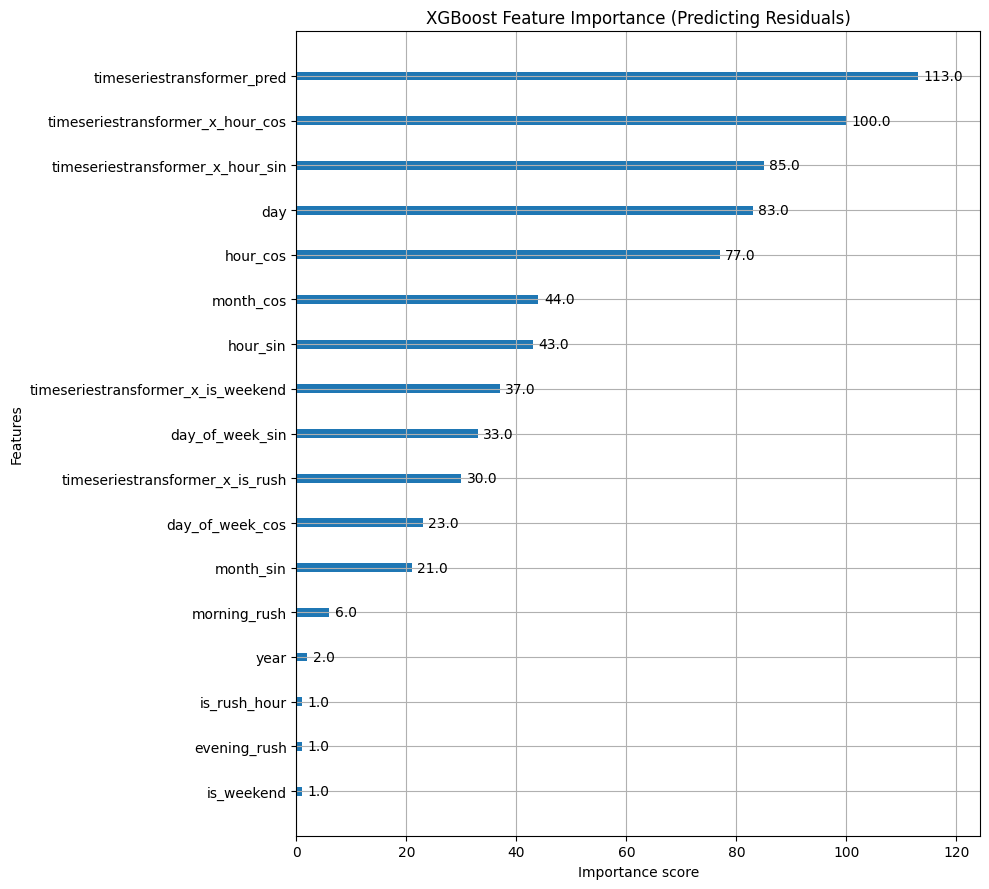

In [ ]:
# === 8. Optimize and Train Refinement Model (XGBoost with Optuna using TimeSeriesTransformer Preds) ===
print("--- Optimizing Refinement Model (XGBoost with Optuna using TimeSeriesTransformer Preds) ---")
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import traceback
import torch
import matplotlib.pyplot as plt # Ensure plt is imported

# --- Clear PyTorch CUDA cache ---
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cleared PyTorch CUDA cache.")

# --- Check for necessary variables (using ALIGNED versions from previous cell) ---
required_vars = [
    'timeseriestransformer_train_pred_scaled', 'train_temporal', 'y_train_scaled_aligned',
    'timeseriestransformer_val_pred_scaled', 'val_temporal', 'y_val_scaled_aligned',
    'timeseriestransformer_test_pred_scaled', 'test_temporal', 'y_test_scaled_aligned',
    'temporal_feature_names', 'scaler', 'y_test_orig_aligned' # Use the aligned original test targets
]
for var in required_vars:
    if var not in locals():
        if var == 'temporal_features' and 'temporal_feature_names' in locals():
            print(f"Warning: '{var}' not found, but 'temporal_feature_names' exists. Proceeding with 'temporal_feature_names'.")
        else:
            raise NameError(f"Variable '{var}' not found. Ensure the previous cell (generating TimeSeriesTransformer preds and aligning data) ran successfully and all variable names are correct (e.g., 'temporal_feature_names' vs 'temporal_features').")

# --- Calculate Residuals (TARGET for XGBoost) ---
# Use aligned targets and predictions
y_train_refine_resid = y_train_scaled_aligned - timeseriestransformer_train_pred_scaled
y_val_refine_resid = y_val_scaled_aligned - timeseriestransformer_val_pred_scaled
y_test_refine_resid = y_test_scaled_aligned - timeseriestransformer_test_pred_scaled # Used for dtest label
print("Calculated residuals for XGBoost target using TimeSeriesTransformer predictions.")

# --- Prepare Base Input Features for Refinement ---
# Combine TimeSeriesTransformer prediction and original temporal features into DataFrames
base_feature_names = ['timeseriestransformer_pred'] + temporal_feature_names
X_train_refine_df = pd.DataFrame(
    np.concatenate((timeseriestransformer_train_pred_scaled.reshape(-1, 1), train_temporal), axis=1),
    columns=base_feature_names
)
X_val_refine_df = pd.DataFrame(
    np.concatenate((timeseriestransformer_val_pred_scaled.reshape(-1, 1), val_temporal), axis=1),
    columns=base_feature_names
)
X_test_refine_df = pd.DataFrame(
    np.concatenate((timeseriestransformer_test_pred_scaled.reshape(-1, 1), test_temporal), axis=1),
    columns=base_feature_names
)

# --- Feature Engineering for XGBoost (Simplified: No Lagged Residuals) ---
print("Adding interaction features...")
interaction_features = []

for df in [X_train_refine_df, X_val_refine_df, X_test_refine_df]:
    # Interaction Features using TimeSeriesTransformer prediction
    df['timeseriestransformer_x_hour_sin'] = df['timeseriestransformer_pred'] * df['hour_sin']
    df['timeseriestransformer_x_hour_cos'] = df['timeseriestransformer_pred'] * df['hour_cos']
    df['timeseriestransformer_x_is_weekend'] = df['timeseriestransformer_pred'] * df['is_weekend']
    df['timeseriestransformer_x_is_rush'] = df['timeseriestransformer_pred'] * df['is_rush_hour']

# Define new feature sets
interaction_features = ['timeseriestransformer_x_hour_sin', 'timeseriestransformer_x_hour_cos', 'timeseriestransformer_x_is_weekend', 'timeseriestransformer_x_is_rush']
all_refinement_features = base_feature_names + interaction_features
print(f"Total refinement features: {len(all_refinement_features)}")

# --- Data is already aligned, no NaN dropping needed ---
y_train_refine_resid_final = y_train_refine_resid
y_val_refine_resid_final = y_val_refine_resid
y_test_refine_resid_final = y_test_refine_resid # For dtest label

timeseriestransformer_train_pred_scaled_final = timeseriestransformer_train_pred_scaled
timeseriestransformer_val_pred_scaled_final = timeseriestransformer_val_pred_scaled
timeseriestransformer_test_pred_scaled_final = timeseriestransformer_test_pred_scaled

y_test_orig_final = y_test_orig_aligned # Use the aligned original test targets

print(f"Shapes being used for XGBoost:")
print(f"Train X: {X_train_refine_df.shape}, Train y: {y_train_refine_resid_final.shape}")
print(f"Val X: {X_val_refine_df.shape}, Val y: {y_val_refine_resid_final.shape}")
print(f"Test X: {X_test_refine_df.shape}, Test y: {y_test_refine_resid_final.shape}")


# --- Create DMatrix ---
X_train_refine_final = X_train_refine_df[all_refinement_features].values
X_val_refine_final = X_val_refine_df[all_refinement_features].values
X_test_refine_final = X_test_refine_df[all_refinement_features].values

dtrain_refine = xgb.DMatrix(X_train_refine_final, label=y_train_refine_resid_final, feature_names=all_refinement_features)
dval_refine = xgb.DMatrix(X_val_refine_final, label=y_val_refine_resid_final, feature_names=all_refinement_features)
dtest_refine = xgb.DMatrix(X_test_refine_final, label=y_test_refine_resid_final, feature_names=all_refinement_features)
# --- End DMatrix ---

# --- Define the objective function for Optuna (Predicting Residuals) ---
def objective_xgb(trial):
    use_gpu = torch.cuda.is_available()
    device_choice = 'cuda' if use_gpu else 'cpu'
    # Force hist for GPU, allow auto for CPU
    tree_method_choice = 'hist' if use_gpu else trial.suggest_categorical('tree_method_cpu', ['exact', 'approx', 'hist'])
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-5, 20.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 20.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'random_state': 42,
        'n_jobs': -1 # Use all available CPU cores
    }
    # Set device and tree_method based on availability
    if use_gpu:
        params['device'] = device_choice
        params['tree_method'] = tree_method_choice
    elif tree_method_choice != 'exact': # CPU only supports exact, approx, hist
        params['tree_method'] = tree_method_choice


    if params['booster'] == 'gbtree':
        params['max_depth'] = trial.suggest_int('max_depth', 3, 12)
        params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 25)
        params['eta'] = trial.suggest_float('eta', 5e-4, 0.4, log=True) # Learning rate
        params['gamma'] = trial.suggest_float('gamma', 1e-9, 10.0, log=True) # Min loss reduction for split
        if params.get('tree_method', 'auto') == 'hist': # grow_policy only for hist
            params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    elif params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth_dart', 3, 12) # Use different name to avoid conflict
        params['eta'] = trial.suggest_float('eta_dart', 5e-4, 0.4, log=True)
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 0.6, log=True)
        params['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 0.6, log=True)

    # Use a wider range for num_boost_round, Optuna + early stopping will handle it
    num_boost_round = trial.suggest_int('num_boost_round', 100, 2000, step=100)
    early_stopping_rounds = 50

    print(f"\n--- Starting Trial {trial.number} with params: {params} ---")
    try:
        bst = xgb.train(
            params,
            dtrain_refine,
            num_boost_round=num_boost_round,
            evals=[(dval_refine, 'validation')],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=100 # Print progress every 100 rounds
        )
        best_rmse = bst.best_score
        trial.set_user_attr("best_iteration", bst.best_iteration)
        print(f"--- Trial {trial.number} finished successfully (best_score={best_rmse:.6f}) ---")
    except RuntimeError as rt_e:
        print(f"Trial {trial.number}: RuntimeError (potentially CUDA OOM) - {rt_e}")
        traceback.print_exc()
        if 'CUDA' in str(rt_e) and torch.cuda.is_available():
            print("Attempting to clear CUDA cache after error...")
            torch.cuda.empty_cache()
        return float('inf') # Fail the trial
    except xgb.core.XGBoostError as xgb_e:
        print(f"Trial {trial.number}: XGBoostError - {xgb_e}")
        traceback.print_exc()
        return float('inf')
    except Exception as e:
        print(f"Trial {trial.number}: General Error - {e}")
        traceback.print_exc()
        return float('inf')

    if np.isnan(best_rmse) or np.isinf(best_rmse):
        print(f"Trial {trial.number}: Invalid RMSE ({best_rmse}).")
        return float('inf')
    return best_rmse

# --- Optuna Study Creation and Callback ---
study_xgb = optuna.create_study(direction='minimize')
def optuna_callback(study, trial):
    if trial.state == optuna.trial.TrialState.COMPLETE:
        print(f"Callback: Trial {trial.number} finished with value (Residual RMSE): {trial.value:.6f}. Best is trial {study.best_trial.number} with value: {study.best_value:.6f}.")
    elif trial.state == optuna.trial.TrialState.FAIL:
        print(f"Callback: Trial {trial.number} failed.")


# --- Run Optimization ---
print("Starting Optuna optimization for XGBoost...")
try:
    # Adjust n_trials and timeout as needed
    study_xgb.optimize(objective_xgb, n_trials=50, timeout=1800, callbacks=[optuna_callback]) # e.g., 50 trials, 30 min timeout
except Exception as e:
    print(f"Optuna optimization process failed: {e}")
    traceback.print_exc()

# --- Process Optimization Results ---
if not study_xgb.trials or study_xgb.best_trial is None or study_xgb.best_value == float('inf'):
    print("Optuna optimization failed or yielded no valid trials. Cannot proceed with XGBoost refinement.")
    final_xgb_refine_model = None
    test_rmse_xgb, test_mae_xgb = float('inf'), float('inf')
    # Fallback uses ORIGINAL TimeSeriesTransformer predictions (aligned)
    final_test_pred_xgb = scaler.inverse_transform(timeseriestransformer_test_pred_scaled_final.reshape(-1, 1)).flatten()
    final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None) # Clip fallback too
else:
    # --- Get Best Parameters and Iteration ---
    best_params_xgb = study_xgb.best_params
    # Remove CPU-specific tree method if present
    best_params_xgb.pop('tree_method_cpu', None)
    best_iteration_optuna = study_xgb.best_trial.user_attrs.get("best_iteration")

    if best_iteration_optuna is None:
        print("Warning: Could not retrieve best_iteration from Optuna trial. Using num_boost_round from params or a default.")
        # Use the suggested num_boost_round if available, otherwise a default
        num_boost_round_final = best_params_xgb.pop('num_boost_round', 1000) # Default to 1000 if not found
    else:
        # Use the best iteration found during Optuna's early stopping
        num_boost_round_final = best_iteration_optuna
        best_params_xgb.pop('num_boost_round', None) # Remove num_boost_round if it was suggested

    print("\nBest hyperparameters found by Optuna (for residuals):")
    print(best_params_xgb)
    print(f"Best validation Residual RMSE (scaled): {study_xgb.best_value:.6f}")
    print(f"Best number of boosting rounds from Optuna trial: {num_boost_round_final}")

    # --- Train Final XGBoost Model on Residuals ---
    print("\nTraining final XGBoost refinement model on residuals...")
    final_params = best_params_xgb.copy()
    final_params['objective'] = 'reg:squarederror'
    final_params['eval_metric'] = 'rmse'
    final_params['random_state'] = 42
    final_params['n_jobs'] = -1
    # Set device/tree_method for final training
    if torch.cuda.is_available():
        final_params['device'] = 'cuda'
        final_params['tree_method'] = 'hist'
    else:
        # Use 'hist' for CPU as well, generally faster for larger datasets
        final_params['tree_method'] = 'hist'


    # Use early stopping in final training as well
    final_early_stopping_rounds = 50

    try:
        final_xgb_refine_model = xgb.train(
            final_params,
            dtrain_refine,
            # Train for the best iteration found + patience, let early stopping find the optimal point again
            num_boost_round=num_boost_round_final + final_early_stopping_rounds,
            evals=[(dtrain_refine, 'train_resid'), (dval_refine, 'val_resid')],
            early_stopping_rounds=final_early_stopping_rounds,
            verbose_eval=100 # Show progress
        )
        # Use the actual best iteration from the final training run
        actual_best_iteration = final_xgb_refine_model.best_iteration
        print(f"Final XGBoost refinement model (predicting residuals) fitted. Best iteration: {actual_best_iteration}")

        # --- Predict Residuals with the final model ---
        xgb_train_pred_scaled_resid = final_xgb_refine_model.predict(dtrain_refine, iteration_range=(0, actual_best_iteration + 1))
        xgb_val_pred_scaled_resid = final_xgb_refine_model.predict(dval_refine, iteration_range=(0, actual_best_iteration + 1))
        xgb_test_pred_scaled_resid = final_xgb_refine_model.predict(dtest_refine, iteration_range=(0, actual_best_iteration + 1))

        # --- Combine ORIGINAL TimeSeriesTransformer prediction and XGBoost residual prediction ---
        final_train_pred_scaled = timeseriestransformer_train_pred_scaled_final + xgb_train_pred_scaled_resid
        final_val_pred_scaled = timeseriestransformer_val_pred_scaled_final + xgb_val_pred_scaled_resid
        final_test_pred_scaled = timeseriestransformer_test_pred_scaled_final + xgb_test_pred_scaled_resid

        # --- Inverse transform the COMBINED predictions ---
        final_train_pred_xgb = scaler.inverse_transform(final_train_pred_scaled.reshape(-1, 1)).flatten()
        final_val_pred_xgb = scaler.inverse_transform(final_val_pred_scaled.reshape(-1, 1)).flatten()
        final_test_pred_xgb = scaler.inverse_transform(final_test_pred_scaled.reshape(-1, 1)).flatten()

        # Clip predictions
        final_train_pred_xgb = np.clip(final_train_pred_xgb, 0, None)
        final_val_pred_xgb = np.clip(final_val_pred_xgb, 0, None)
        final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None)

        # --- Evaluate Final COMBINED XGBoost Refinement ---
        print("\n--- Optimized XGBoost Refinement Evaluation (Test Set - Combined Preds) ---")
        # Use ALIGNED ORIGINAL test targets for evaluation
        test_rmse_xgb = np.sqrt(mean_squared_error(y_test_orig_final, final_test_pred_xgb))
        test_mae_xgb = mean_absolute_error(y_test_orig_final, final_test_pred_xgb)
        print(f"Optimized (TimeSeriesTransformer + XGBoost) - Test RMSE: {test_rmse_xgb:.2f}, Test MAE: {test_mae_xgb:.2f}")

        # --- Feature Importance ---
        try:
            fig, ax = plt.subplots(figsize=(10, max(8, len(all_refinement_features) // 2)))
            xgb.plot_importance(final_xgb_refine_model, ax=ax, max_num_features=40)
            plt.title("XGBoost Feature Importance (Predicting Residuals)")
            plt.tight_layout()
            plt.show()
        except Exception as plot_e:
            print(f"Could not plot feature importance: {plot_e}")

    except xgb.core.XGBoostError as xgb_e:
        print(f"XGBoostError during final fitting/prediction: {xgb_e}")
        traceback.print_exc()
        test_rmse_xgb, test_mae_xgb = float('inf'), float('inf')
        # Fallback uses ORIGINAL TimeSeriesTransformer predictions (aligned)
        final_test_pred_xgb = scaler.inverse_transform(timeseriestransformer_test_pred_scaled_final.reshape(-1, 1)).flatten()
        final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None)
    except Exception as e:
        print(f"General error during final XGBoost fitting/prediction: {e}")
        traceback.print_exc()
        test_rmse_xgb, test_mae_xgb = float('inf'), float('inf')
        # Fallback uses ORIGINAL TimeSeriesTransformer predictions (aligned)
        final_test_pred_xgb = scaler.inverse_transform(timeseriestransformer_test_pred_scaled_final.reshape(-1, 1)).flatten()
        final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None)


--- Training Refinement Model (Simple NN using TimeSeriesTransformer Preds) ---

NN Refinement Model Architecture:
RefinementNN(
  (layers): ModuleList(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
Starting NN refinement training...
Epoch 1/100, NN Train Loss (Resid): 0.168723, NN Val Loss (Resid): 0.165320
  -> New best NN val loss: 0.165320. Saving model.
Epoch 2/100, NN Train Loss (Resid): 0.080541, NN Val Loss (Resid): 0.163384
  -> New

C:\Users\PLN\AppData\Local\Temp\ipykernel_5748\4289151178.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_refine_model.load_state_dict(torch.load(nn_model_save_path

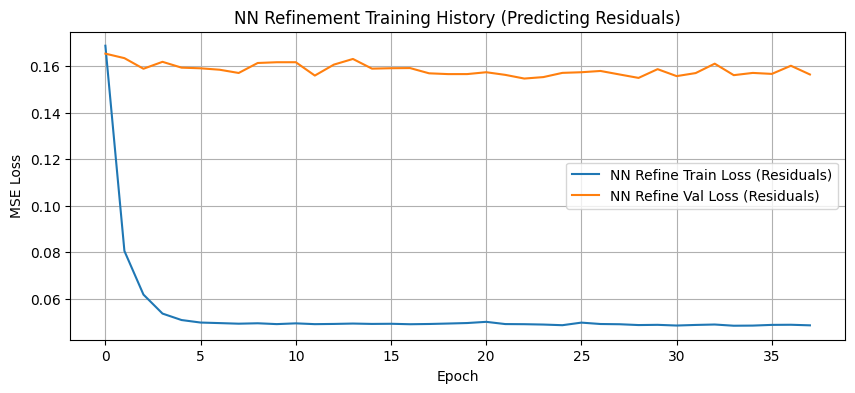


--- Optimized NN Refinement Evaluation (Test Set - Combined Preds) ---
Optimized (TimeSeriesTransformer + NN) - Test RMSE: 10.75, Test MAE: 6.79

--- Final Comparison on Test Set (TimeSeriesTransformer Base) ---
TimeSeriesTransformer Only - Test RMSE: 10.88, Test MAE: 6.88


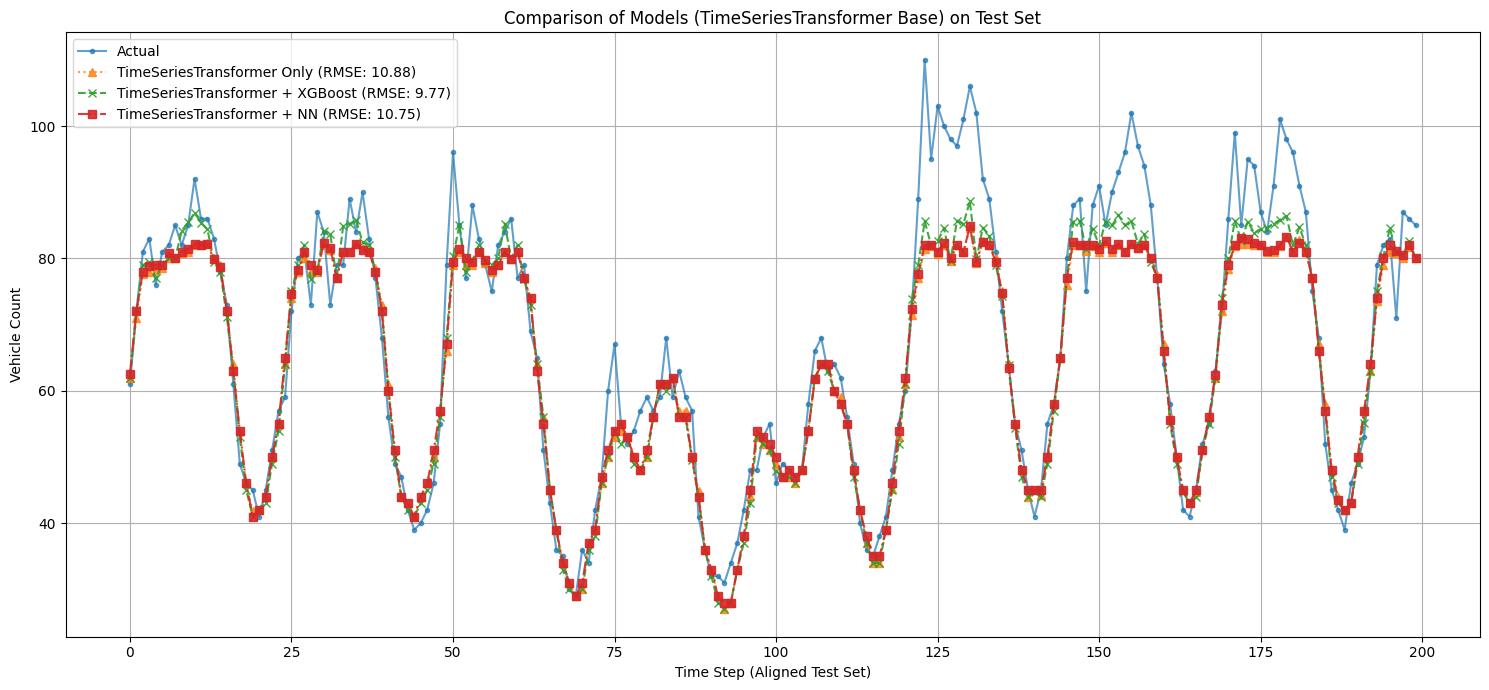


===== FINAL RESULTS SUMMARY (Test Set - TimeSeriesTransformer Base) =====
                             Model       RMSE       MAE
1  TimeSeriesTransformer + XGBoost   9.772217  6.141897
2       TimeSeriesTransformer + NN  10.746893  6.786226
0       TimeSeriesTransformer Only  10.875729  6.877570


In [ ]:
# === 9. Train and Evaluate Refinement Model (Simple NN using TimeSeriesTransformer Preds) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import os

print("\n--- Training Refinement Model (Simple NN using TimeSeriesTransformer Preds) ---")

# --- Check for necessary variables (using ALIGNED versions from previous cells) ---
required_vars_nn = [
    'X_train_refine_df', 'X_val_refine_df', 'X_test_refine_df', # DataFrames with features
    'y_train_refine_resid_final', 'y_val_refine_resid_final', 'y_test_refine_resid_final', # Residuals (NN targets)
    'timeseriestransformer_train_pred_scaled_final', 'timeseriestransformer_val_pred_scaled_final', 'timeseriestransformer_test_pred_scaled_final', # Base predictions
    'all_refinement_features', # List of feature names used in XGBoost/NN
    'scaler', # The scaler used for TimeSeriesTransformer targets
    'y_test_orig_final', # Aligned original test targets
    'device' # PyTorch device
]
for var in required_vars_nn:
    if var not in locals():
        raise NameError(f"Variable '{var}' for NN refinement not found. Ensure previous cells (TimeSeriesTransformer eval, XGBoost refinement) ran successfully.")


class RefinementNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_rate=0.4):
        """
        Enhanced Feed-Forward Neural Network for refinement with configurable layers and LeakyReLU.

        Args:
            input_dim (int): Dimension of the input features.
            hidden_dims (list): List of integers specifying the size of each hidden layer.
            output_dim (int): Dimension of the output (usually 1).
            dropout_rate (float): Dropout probability.
        """
        super(RefinementNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)

        # Input layer connection
        current_dim = input_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(current_dim, h_dim))
            # Add BatchNorm before activation for hidden layers
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            current_dim = h_dim

        # Output layer
        self.output_layer = nn.Linear(current_dim, output_dim)

    def forward(self, x):
        # Pass through hidden layers
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Apply BatchNorm only if the batch size is greater than 1
            if x.size(0) > 1:
                x = self.batch_norms[i](x)
            # Use LeakyReLU activation
            x = F.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)

        # Output layer
        x = self.output_layer(x)
        return x

# Prepare data for NN refinement (Using features derived from TimeSeriesTransformer)
# Use the same feature set as XGBoost
X_train_refine_tensor = torch.tensor(X_train_refine_df[all_refinement_features].values, dtype=torch.float32).to(device)
X_val_refine_tensor = torch.tensor(X_val_refine_df[all_refinement_features].values, dtype=torch.float32).to(device)
X_test_refine_tensor = torch.tensor(X_test_refine_df[all_refinement_features].values, dtype=torch.float32).to(device)

# Target tensors are the residuals calculated from TimeSeriesTransformer predictions
y_train_refine_tensor = torch.tensor(y_train_refine_resid_final, dtype=torch.float32).unsqueeze(1).to(device)
y_val_refine_tensor = torch.tensor(y_val_refine_resid_final, dtype=torch.float32).unsqueeze(1).to(device)
# y_test_refine_tensor is not strictly needed for training/validation but can be defined for consistency
y_test_refine_tensor = torch.tensor(y_test_refine_resid_final, dtype=torch.float32).unsqueeze(1).to(device)

# --- Instantiate NN Model ---
nn_refine_model = RefinementNN(
    input_dim=X_train_refine_tensor.shape[1]
).to(device)

print("\nNN Refinement Model Architecture:")
print(nn_refine_model)

# --- Setup Training ---
nn_criterion = nn.MSELoss()
nn_optimizer = torch.optim.AdamW(nn_refine_model.parameters(), lr=0.001, weight_decay=1e-4)

nn_train_dataset = TensorDataset(X_train_refine_tensor, y_train_refine_tensor)
nn_train_loader = DataLoader(nn_train_dataset, batch_size=128, shuffle=True)

nn_epochs = 100 # Adjust as needed
nn_patience = 15
nn_patience_counter = 0
best_nn_val_loss = float('inf')
nn_train_losses = []
nn_val_losses = []
nn_model_save_path = "best_timeseriestransformer_nn_refine_model.pt" # Updated save path

# --- Training Loop ---
print("Starting NN refinement training...")
for epoch in range(nn_epochs):
    nn_refine_model.train()
    epoch_loss = 0
    for batch_X, batch_y_resid in nn_train_loader:
        nn_optimizer.zero_grad()
        outputs = nn_refine_model(batch_X) # Predict residuals
        loss = nn_criterion(outputs, batch_y_resid)
        loss.backward()
        nn_optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(nn_train_loader)
    nn_train_losses.append(avg_train_loss)

    # Validation
    nn_refine_model.eval()
    with torch.no_grad():
        val_outputs = nn_refine_model(X_val_refine_tensor) # Predict residuals
        val_loss = nn_criterion(val_outputs, y_val_refine_tensor).item()
        nn_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{nn_epochs}, NN Train Loss (Resid): {avg_train_loss:.6f}, NN Val Loss (Resid): {val_loss:.6f}")

    # Early stopping
    if val_loss < best_nn_val_loss:
        best_nn_val_loss = val_loss
        torch.save(nn_refine_model.state_dict(), nn_model_save_path)
        print(f"  -> New best NN val loss: {best_nn_val_loss:.6f}. Saving model.")
        nn_patience_counter = 0
    else:
        nn_patience_counter += 1
        if nn_patience_counter >= nn_patience:
            print(f"Early stopping NN refinement training at epoch {epoch+1}")
            break

# --- Load Best NN Model ---
if os.path.exists(nn_model_save_path):
    nn_refine_model.load_state_dict(torch.load(nn_model_save_path))
    print(f"\nBest NN refinement model loaded from '{nn_model_save_path}'.")
else:
    print(f"\nWarning: '{nn_model_save_path}' not found. Using model from the last epoch.")


# --- Plot NN Losses ---
plt.figure(figsize=(10, 4))
plt.plot(nn_train_losses, label='NN Refine Train Loss (Residuals)')
plt.plot(nn_val_losses, label='NN Refine Val Loss (Residuals)')
plt.title('NN Refinement Training History (Predicting Residuals)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Predict Residuals with NN ---
nn_refine_model.eval()
with torch.no_grad():
    nn_train_pred_scaled_resid = nn_refine_model(X_train_refine_tensor).squeeze().cpu().numpy()
    nn_val_pred_scaled_resid = nn_refine_model(X_val_refine_tensor).squeeze().cpu().numpy()
    nn_test_pred_scaled_resid = nn_refine_model(X_test_refine_tensor).squeeze().cpu().numpy()

# --- Combine TimeSeriesTransformer prediction and NN residual prediction ---
final_train_pred_scaled_nn = timeseriestransformer_train_pred_scaled_final + nn_train_pred_scaled_resid
final_val_pred_scaled_nn = timeseriestransformer_val_pred_scaled_final + nn_val_pred_scaled_resid
final_test_pred_scaled_nn = timeseriestransformer_test_pred_scaled_final + nn_test_pred_scaled_resid

# --- Inverse transform the COMBINED predictions ---
final_train_pred_nn = scaler.inverse_transform(final_train_pred_scaled_nn.reshape(-1, 1)).flatten()
final_val_pred_nn = scaler.inverse_transform(final_val_pred_scaled_nn.reshape(-1, 1)).flatten()
final_test_pred_nn = scaler.inverse_transform(final_test_pred_scaled_nn.reshape(-1, 1)).flatten()

# Clip predictions
final_train_pred_nn = np.clip(final_train_pred_nn, 0, None)
final_val_pred_nn = np.clip(final_val_pred_nn, 0, None)
final_test_pred_nn = np.clip(final_test_pred_nn, 0, None)

# --- Evaluate Final COMBINED NN Refinement ---
print("\n--- Optimized NN Refinement Evaluation (Test Set - Combined Preds) ---")
# Use ALIGNED ORIGINAL test targets for evaluation
test_rmse_nn = np.sqrt(mean_squared_error(y_test_orig_final, final_test_pred_nn))
test_mae_nn = mean_absolute_error(y_test_orig_final, final_test_pred_nn)
print(f"Optimized (TimeSeriesTransformer + NN) - Test RMSE: {test_rmse_nn:.2f}, Test MAE: {test_mae_nn:.2f}")


# === 10. Final Comparison Plot (TimeSeriesTransformer Base) ===
print("\n--- Final Comparison on Test Set (TimeSeriesTransformer Base) ---")

# Get TimeSeriesTransformer-only predictions (inverse transformed) - Use aligned ones
# timeseriestransformer_test_pred_orig was calculated in the TimeSeriesTransformer evaluation cell
# timeseriestransformer_rmse and timeseriestransformer_mae were also calculated there.
if 'timeseriestransformer_rmse' not in locals() or 'timeseriestransformer_mae' not in locals():
    print("Warning: 'timeseriestransformer_rmse' or 'timeseriestransformer_mae' not found. Using placeholders for TimeSeriesTransformer-only metrics.")
    timeseriestransformer_rmse = float('inf')
    timeseriestransformer_mae = float('inf')
if 'timeseriestransformer_test_pred_orig' not in locals():
    print("Warning: 'timeseriestransformer_test_pred_orig' not found. Plotting for TimeSeriesTransformer-only will be skipped.")
    timeseriestransformer_test_pred_orig = np.array([]) # Placeholder to prevent error if it's missing

print(f"TimeSeriesTransformer Only - Test RMSE: {timeseriestransformer_rmse:.2f}, Test MAE: {timeseriestransformer_mae:.2f}")


plt.figure(figsize=(15, 7))
# Plot a subset for clarity (e.g., first 200 points of the aligned test set)
plot_range = range(min(200, len(y_test_orig_final)))
plt.plot(plot_range, y_test_orig_final[plot_range], label='Actual', marker='.', linestyle='-', alpha=0.7)

if len(timeseriestransformer_test_pred_orig) == len(y_test_orig_final):
    plt.plot(plot_range, timeseriestransformer_test_pred_orig[plot_range], label=f'TimeSeriesTransformer Only (RMSE: {timeseriestransformer_rmse:.2f})', marker='^', linestyle=':', alpha=0.8)
else:
    if len(timeseriestransformer_test_pred_orig) > 0 :
        print(f"Warning: TimeSeriesTransformer prediction length ({len(timeseriestransformer_test_pred_orig)}) doesn't match target length ({len(y_test_orig_final)}). Skipping TimeSeriesTransformer-only plot.")


if 'final_test_pred_xgb' in locals() and len(final_test_pred_xgb) == len(y_test_orig_final):
    plt.plot(plot_range, final_test_pred_xgb[plot_range], label=f'TimeSeriesTransformer + XGBoost (RMSE: {test_rmse_xgb:.2f})', marker='x', linestyle='--', alpha=0.9)
else:
    print(f"Warning: XGBoost prediction length might mismatch target length or 'final_test_pred_xgb' not found. Skipping plot.")

if len(final_test_pred_nn) == len(y_test_orig_final):
    plt.plot(plot_range, final_test_pred_nn[plot_range], label=f'TimeSeriesTransformer + NN (RMSE: {test_rmse_nn:.2f})', marker='s', linestyle='-.', alpha=0.9)
else:
    print(f"Warning: NN prediction length ({len(final_test_pred_nn)}) doesn't match target length ({len(y_test_orig_final)}). Skipping plot.")


plt.title('Comparison of Models (TimeSeriesTransformer Base) on Test Set')
plt.xlabel('Time Step (Aligned Test Set)')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Final Results Summary (TimeSeriesTransformer Base) ---
print("\n===== FINAL RESULTS SUMMARY (Test Set - TimeSeriesTransformer Base) =====")
results_data = {
    'Model': ['TimeSeriesTransformer Only', 'TimeSeriesTransformer + XGBoost', 'TimeSeriesTransformer + NN'],
    'RMSE': [timeseriestransformer_rmse, test_rmse_xgb, test_rmse_nn],
    'MAE': [timeseriestransformer_mae, test_mae_xgb, test_mae_nn]
}
if 'test_rmse_xgb' not in locals() or test_rmse_xgb == float('inf'):
    results_data['RMSE'][1] = float('inf')
    results_data['MAE'][1] = float('inf')

results_df = pd.DataFrame(results_data)
print(results_df.sort_values('RMSE'))

In [ ]:
print("--- Checking variable existence ---")
vars_to_check = [
    'y_test_orig_final',
    'timeseriestransformer_test_pred_orig', # Changed from patchtsmixer_test_pred_orig if it was meant to be the base model
    'final_test_pred_xgb',
    'final_test_pred_nn'
]
for var_name in vars_to_check:
    if var_name in locals():
        print(f"Variable '{var_name}' exists. Type: {type(locals()[var_name])}, Shape/Length: {getattr(locals()[var_name], 'shape', len(locals()[var_name]))}")
    else:
        print(f"Variable '{var_name}' is MISSING.")

# Optional: Print all local variables if needed
# print("\nAll local variables:", list(locals().keys()))

--- Checking variable existence ---
Variable 'y_test_orig_final' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2583,)
Variable 'timeseriestransformer_test_pred_orig' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2583,)
Variable 'final_test_pred_xgb' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2583,)
Variable 'final_test_pred_nn' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2583,)



===== LAST 24 HOURS RESULTS SUMMARY (Test Set - TimeSeriesTransformer Base) =====
--- Checking variables within comparison cell scope ---
Variable 'y_test_orig_final' exists in this cell's scope.
Variable 'timeseriestransformer_test_pred_orig' exists in this cell's scope.
Variable 'final_test_pred_xgb' exists in this cell's scope.
Variable 'final_test_pred_nn' exists in this cell's scope.
--- All required variables confirmed within cell scope. Proceeding... ---
                             Model       RMSE       MAE
1  TimeSeriesTransformer + XGBoost   9.349379  7.121810
2       TimeSeriesTransformer + NN  11.069529  8.449801
0       TimeSeriesTransformer Only  11.307171  8.594972


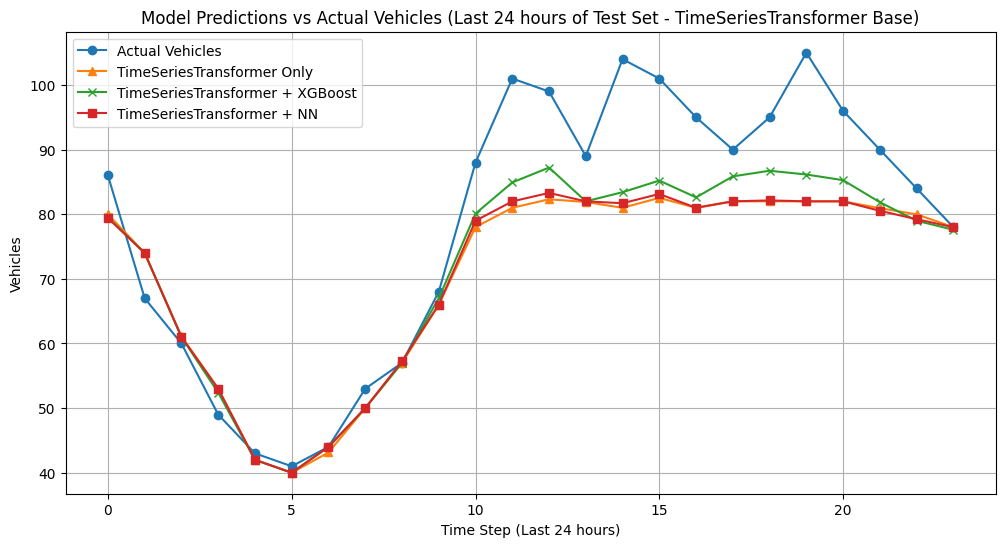

In [ ]:
# === 11. Last 24 Hours Comparison (TimeSeriesTransformer Base) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n===== LAST 24 HOURS RESULTS SUMMARY (Test Set - TimeSeriesTransformer Base) =====")

# --- Explicitly check variables INSIDE this cell's scope ---
variables_exist_in_cell = True
required_vars_last24 = [
    'y_test_orig_final',
    'timeseriestransformer_test_pred_orig',
    'final_test_pred_xgb',
    'final_test_pred_nn'
]
missing_vars_in_cell = []

print("--- Checking variables within comparison cell scope ---")
for var_name in required_vars_last24:
    if var_name not in locals():
        variables_exist_in_cell = False
        missing_vars_in_cell.append(var_name)
        print(f"!!! Variable '{var_name}' is MISSING in this cell's scope !!!")
    else:
        print(f"Variable '{var_name}' exists in this cell's scope.")

# --- Proceed only if all variables are confirmed within this cell ---
if not variables_exist_in_cell:
    print(f"Error: Missing variables required for last 24-hour comparison: {', '.join(missing_vars_in_cell)}")
    print("This indicates an issue with variable scope or kernel state. Please re-run preceding cells or restart the kernel.")
else:
    print("--- All required variables confirmed within cell scope. Proceeding... ---")
    last_24_hours = 24

    # --- Check lengths (using the confirmed variables) ---
    min_len_last24 = len(y_test_orig_final)
    can_compare_timeseriestransformer = True
    can_compare_xgb = True
    can_compare_nn = True

    if len(timeseriestransformer_test_pred_orig) != min_len_last24:
        print(f"Warning: Length mismatch for TimeSeriesTransformer predictions ({len(timeseriestransformer_test_pred_orig)} vs {min_len_last24}). Cannot calculate last 24h metrics.")
        can_compare_timeseriestransformer = False

    if 'final_test_pred_xgb' not in locals() or len(final_test_pred_xgb) != min_len_last24:
        print(f"Warning: Length mismatch or missing 'final_test_pred_xgb'. Cannot calculate last 24h metrics for XGBoost.")
        can_compare_xgb = False

    if 'final_test_pred_nn' not in locals() or len(final_test_pred_nn) != min_len_last24:
        print(f"Warning: Length mismatch or missing 'final_test_pred_nn'. Cannot calculate last 24h metrics for NN.")
        can_compare_nn = False


    # --- Calculate Metrics for Last 24 Hours ---
    models_last24 = []
    rmse_last24 = []
    mae_last24 = []

    if can_compare_timeseriestransformer:
        models_last24.append('TimeSeriesTransformer Only')
        rmse_last24.append(np.sqrt(mean_squared_error(y_test_orig_final[-last_24_hours:], timeseriestransformer_test_pred_orig[-last_24_hours:])))
        mae_last24.append(mean_absolute_error(y_test_orig_final[-last_24_hours:], timeseriestransformer_test_pred_orig[-last_24_hours:]))

    if can_compare_xgb:
        models_last24.append('TimeSeriesTransformer + XGBoost')
        rmse_last24.append(np.sqrt(mean_squared_error(y_test_orig_final[-last_24_hours:], final_test_pred_xgb[-last_24_hours:])))
        mae_last24.append(mean_absolute_error(y_test_orig_final[-last_24_hours:], final_test_pred_xgb[-last_24_hours:]))
    else:
        if 'TimeSeriesTransformer + XGBoost' not in models_last24:
            models_last24.append('TimeSeriesTransformer + XGBoost')
            rmse_last24.append(float('inf'))
            mae_last24.append(float('inf'))


    if can_compare_nn:
        models_last24.append('TimeSeriesTransformer + NN')
        rmse_last24.append(np.sqrt(mean_squared_error(y_test_orig_final[-last_24_hours:], final_test_pred_nn[-last_24_hours:])))
        mae_last24.append(mean_absolute_error(y_test_orig_final[-last_24_hours:], final_test_pred_nn[-last_24_hours:]))
    else:
        if 'TimeSeriesTransformer + NN' not in models_last24:
            models_last24.append('TimeSeriesTransformer + NN')
            rmse_last24.append(float('inf'))
            mae_last24.append(float('inf'))

    last_24_hours_results_data = {
        'Model': models_last24,
        'RMSE': rmse_last24,
        'MAE': mae_last24
    }

    if last_24_hours_results_data['Model']:
        last_24_hours_results_df = pd.DataFrame(last_24_hours_results_data)
        print(last_24_hours_results_df.sort_values('RMSE'))

        # --- Plot Last 24 Hours ---
        plt.figure(figsize=(12, 6))
        plt.plot(range(last_24_hours), y_test_orig_final[-last_24_hours:], label='Actual Vehicles', marker='o')

        if can_compare_timeseriestransformer:
            plt.plot(range(last_24_hours), timeseriestransformer_test_pred_orig[-last_24_hours:], label='TimeSeriesTransformer Only', marker='^')
        if can_compare_xgb:
            plt.plot(range(last_24_hours), final_test_pred_xgb[-last_24_hours:], label='TimeSeriesTransformer + XGBoost', marker='x')
        if can_compare_nn:
            plt.plot(range(last_24_hours), final_test_pred_nn[-last_24_hours:], label='TimeSeriesTransformer + NN', marker='s')

        plt.title('Model Predictions vs Actual Vehicles (Last 24 hours of Test Set - TimeSeriesTransformer Base)')
        plt.xlabel('Time Step (Last 24 hours)')
        plt.ylabel('Vehicles')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Could not generate last 24-hour comparison due to missing data or length mismatches.")


--- Training NN to Mimic TimeSeriesTransformer+XGBoost (Knowledge Distillation - Further Enhanced) ---
Using TimeSeriesTransformer+XGBoost predictions as teacher for distillation.
Distillation Target Shape (Train): torch.Size([9878, 1])
Distillation Target Shape (Val): torch.Size([1123, 1])
Distillation Input Shape (Train): torch.Size([9878, 18])

Distilled NN Model Architecture (Further Enhanced):
RefinementNN(
  (layers): ModuleList(
    (0): Linear(in_features=18, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, mom

c:\Users\PLN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500, Distill Train Loss: 0.073967, Distill Val Loss: 0.010911, LR: 0.000500
  -> New best distillation val loss: 0.010911. Saving model to best_timeseriestransformer_distilled_nn_model_further_enhanced.pt
Epoch 2/500, Distill Train Loss: 0.039708, Distill Val Loss: 0.013415, LR: 0.000500
Epoch 3/500, Distill Train Loss: 0.033630, Distill Val Loss: 0.007199, LR: 0.000500
  -> New best distillation val loss: 0.007199. Saving model to best_timeseriestransformer_distilled_nn_model_further_enhanced.pt
Epoch 4/500, Distill Train Loss: 0.030632, Distill Val Loss: 0.016814, LR: 0.000500
Epoch 5/500, Distill Train Loss: 0.030037, Distill Val Loss: 0.019274, LR: 0.000500
Epoch 6/500, Distill Train Loss: 0.026934, Distill Val Loss: 0.023348, LR: 0.000500
Epoch 7/500, Distill Train Loss: 0.025950, Distill Val Loss: 0.015551, LR: 0.000500
Epoch 8/500, Distill Train Loss: 0.027826, Distill Val Loss: 0.025433, LR: 0.000500
Epoch 9/500, Distill Train Loss: 0.026343, Distill Val Loss: 0.016306,

C:\Users\PLN\AppData\Local\Temp\ipykernel_5748\1346851680.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distilled_nn_model.load_state_dict(torch.load(distill_model_s

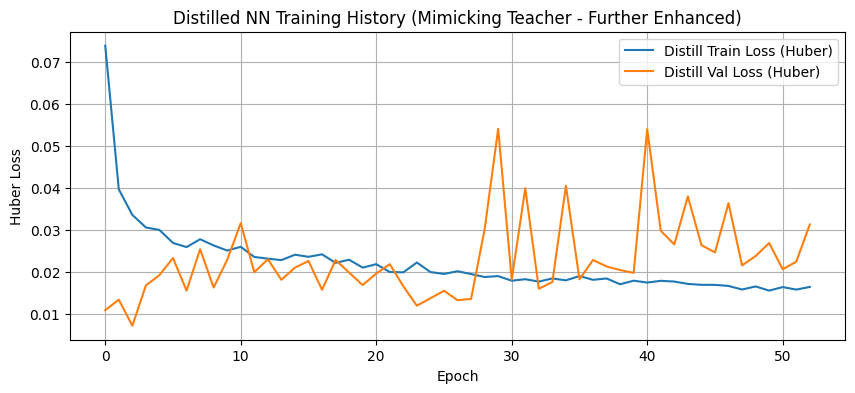


Distillation training complete. Proceed to the next cell for evaluation of the distilled model.
Cleared some distillation-specific tensors from CUDA memory.


In [ ]:
# === 11. Train Model to Mimic TimeSeriesTransformer+XGBoost (Knowledge Distillation using NN) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time # Added for timing

print("\n--- Training NN to Mimic TimeSeriesTransformer+XGBoost (Knowledge Distillation - Further Enhanced) ---")

# --- Check if necessary variables exist ---
required_vars_distill = [
    'X_train_refine_tensor', 'X_val_refine_tensor', 'X_test_refine_tensor', # Inputs from NN refinement cell
    'timeseriestransformer_train_pred_scaled_final', 'timeseriestransformer_val_pred_scaled_final', # Base TST preds from XGBoost cell
    'y_test_orig_final', # Original test targets (aligned)
    'scaler', # Scaler for inverse transform
    'device', # PyTorch device
    'RefinementNN' # The NN class defined in NN refinement cell
    # 'final_train_pred_scaled', 'final_val_pred_scaled' (from XGBoost cell) are optional, checked later
    # 'final_xgb_refine_model' (from XGBoost cell) is optional, checked later
]
missing_vars = []
for var_name in required_vars_distill:
    if var_name not in locals():
        missing_vars.append(var_name)

if missing_vars:
    raise NameError(f"Error: Missing variables required for distillation: {', '.join(missing_vars)}. Ensure previous cells ran successfully.")

# --- Determine Teacher Predictions ---
# These are the scaled predictions that the distilled NN will try to mimic.
y_teacher_train_scaled_np = None
y_teacher_val_scaled_np = None

if 'final_xgb_refine_model' in locals() and final_xgb_refine_model is not None and \
    'final_train_pred_scaled' in locals() and 'final_val_pred_scaled' in locals():
    print("Using TimeSeriesTransformer+XGBoost predictions as teacher for distillation.")
    # These 'final_..._pred_scaled' are TimeSeriesTransformer_base + XGBoost_residual predictions from XGBoost cell
    y_teacher_train_scaled_np = np.array(final_train_pred_scaled)
    y_teacher_val_scaled_np = np.array(final_val_pred_scaled)
else:
    print("Warning: TimeSeriesTransformer+XGBoost model/predictions not found or XGBoost Optuna failed.")
    print("Using TimeSeriesTransformer-only predictions as teacher for distillation.")
    # Fallback to using the base TimeSeriesTransformer predictions (aligned)
    if 'timeseriestransformer_train_pred_scaled_final' in locals() and \
        'timeseriestransformer_val_pred_scaled_final' in locals():
        y_teacher_train_scaled_np = np.array(timeseriestransformer_train_pred_scaled_final)
        y_teacher_val_scaled_np = np.array(timeseriestransformer_val_pred_scaled_final)
    else:
        raise NameError("Fallback TimeSeriesTransformer predictions ('timeseriestransformer_train_pred_scaled_final', etc.) not found. Cannot proceed.")

# Convert teacher targets to Tensors, unsqueeze for loss calculation
y_train_distill_target_tensor = torch.tensor(y_teacher_train_scaled_np, dtype=torch.float32).unsqueeze(1).to(device)
y_val_distill_target_tensor = torch.tensor(y_teacher_val_scaled_np, dtype=torch.float32).unsqueeze(1).to(device)

print(f"Distillation Target Shape (Train): {y_train_distill_target_tensor.shape}")
print(f"Distillation Target Shape (Val): {y_val_distill_target_tensor.shape}")
print(f"Distillation Input Shape (Train): {X_train_refine_tensor.shape}") # Input is the same as refinement models

# --- Instantiate a NEW NN Model for Distillation (Further Enhanced Architecture) ---
# Using the RefinementNN class defined in the previous NN refinement cell.
distilled_nn_model = RefinementNN(
    input_dim=X_train_refine_tensor.shape[1], # Input dim is number of refinement features
    hidden_dims=[512, 256, 128, 64, 32], # Enhanced complexity
    output_dim=1,
    dropout_rate=0.2 # Adjusted dropout
).to(device)

print("\nDistilled NN Model Architecture (Further Enhanced):")
print(distilled_nn_model)

# --- Define Optimizer, Criterion, and Scheduler (Further Enhanced Training Params) ---
distill_criterion = nn.HuberLoss(delta=1.0) # HuberLoss for robustness
distill_optimizer = torch.optim.AdamW(distilled_nn_model.parameters(), lr=5e-4, weight_decay=1e-4)
distill_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(distill_optimizer, 'min', factor=0.5, patience=20, verbose=True)

# --- Create DataLoaders (Use Refinement inputs, NEW targets) ---
distill_train_dataset = TensorDataset(X_train_refine_tensor, y_train_distill_target_tensor)
distill_train_loader = DataLoader(distill_train_dataset, batch_size=64, shuffle=True)

distill_val_dataset = TensorDataset(X_val_refine_tensor, y_val_distill_target_tensor)
distill_val_loader = DataLoader(distill_val_dataset, batch_size=256, shuffle=False)

# --- Training Loop (Further Enhanced Training Params) ---
distill_epochs = 500
distill_patience = 50
distill_patience_counter = 0
best_distill_val_loss = float('inf')
distill_train_losses = []
distill_val_losses = []
distill_model_save_path = "best_timeseriestransformer_distilled_nn_model_further_enhanced.pt"

print("\nStarting Distillation Training (NN mimicking Teacher - Further Enhanced)...")
training_start_time = time.time()
for epoch in range(distill_epochs):
    distilled_nn_model.train()
    epoch_train_loss = 0.0
    batch_count = 0
    for batch_X, batch_y_target in distill_train_loader:
        distill_optimizer.zero_grad()
        outputs = distilled_nn_model(batch_X) # Predict the teacher's (scaled) value
        loss = distill_criterion(outputs, batch_y_target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(distilled_nn_model.parameters(), max_norm=1.0)
        distill_optimizer.step()
        epoch_train_loss += loss.item()
        batch_count += 1

    avg_train_loss = epoch_train_loss / batch_count if batch_count > 0 else 0.0
    distill_train_losses.append(avg_train_loss)

    # Validation
    distilled_nn_model.eval()
    epoch_val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for batch_X_val, batch_y_val_target in distill_val_loader:
            val_outputs = distilled_nn_model(batch_X_val)
            loss = distill_criterion(val_outputs, batch_y_val_target)
            epoch_val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = epoch_val_loss / val_batch_count if val_batch_count > 0 else 0.0
    distill_val_losses.append(avg_val_loss)
    distill_scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{distill_epochs}, Distill Train Loss: {avg_train_loss:.6f}, Distill Val Loss: {avg_val_loss:.6f}, LR: {distill_optimizer.param_groups[0]['lr']:.6f}")

    if avg_val_loss < best_distill_val_loss:
        best_distill_val_loss = avg_val_loss
        torch.save(distilled_nn_model.state_dict(), distill_model_save_path)
        distill_patience_counter = 0
        print(f"  -> New best distillation val loss: {best_distill_val_loss:.6f}. Saving model to {distill_model_save_path}")
    else:
        distill_patience_counter += 1
        if distill_patience_counter >= distill_patience:
            print(f"Early stopping distillation training at epoch {epoch+1}")
            break

training_end_time = time.time()
print(f"Distillation training loop finished in {training_end_time - training_start_time:.2f} seconds.")

# --- Load Best Distilled Model ---
if os.path.exists(distill_model_save_path):
    distilled_nn_model.load_state_dict(torch.load(distill_model_save_path, map_location=device))
    print(f"\nBest distilled NN model loaded from '{distill_model_save_path}'.")
else:
    print(f"\nWarning: '{distill_model_save_path}' not found. Using the model from the last training epoch.")

# --- Plot Distillation Losses ---
plt.figure(figsize=(10, 4))
plt.plot(distill_train_losses, label='Distill Train Loss (Huber)')
plt.plot(distill_val_losses, label='Distill Val Loss (Huber)')
plt.title('Distilled NN Training History (Mimicking Teacher - Further Enhanced)')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nDistillation training complete. Proceed to the next cell for evaluation of the distilled model.")

# --- Clear CUDA cache (selectively) ---
if torch.cuda.is_available():
    # Keep: distilled_nn_model, X_test_refine_tensor, scaler, y_test_orig_final, device for next cell
    # Delete: training/validation specific tensors and dataloaders for distillation
    vars_to_delete_from_cuda = [
        'X_train_refine_tensor', 'y_train_distill_target_tensor', 'distill_train_dataset', 'distill_train_loader',
        'X_val_refine_tensor', 'y_val_distill_target_tensor', 'distill_val_dataset', 'distill_val_loader'
    ]
    for var_name in vars_to_delete_from_cuda:
        if var_name in locals():
            try:
                del locals()[var_name]
            except NameError:
                pass # Already deleted or never existed in this scope
    torch.cuda.empty_cache()
    print("Cleared some distillation-specific tensors from CUDA memory.")


--- Evaluating Distilled NN Model ---
Distilled model and test input tensor found. Attempting prediction.
Distilled NN predictions generated. Shape: (2583,)
Attempting inverse transform and metrics calculation.

Distilled NN - Test RMSE: 11.03
Distilled NN - Test MAE: 7.22

--- Comparison Table ---
                                Model   RMSE   MAE
1     TimeSeriesTransformer + XGBoost   9.77  6.14
2  TimeSeriesTransformer + NN (Resid)  10.75  6.79
0          TimeSeriesTransformer Only  10.88  6.88
3            Distilled NN (Mimic XGB)  11.03  7.22

Attempting to plot comparison.


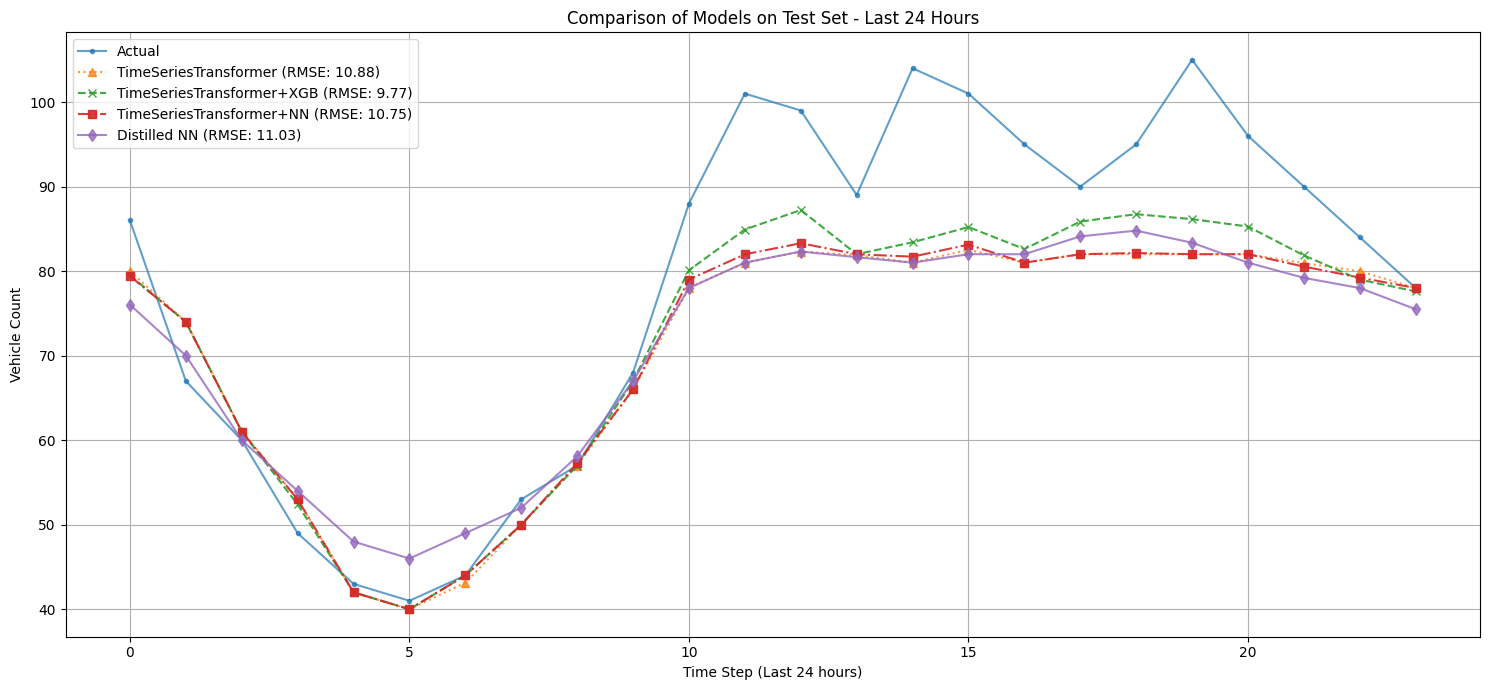

Deleted X_test_refine_tensor.
Cleared CUDA cache.


In [ ]:
# === 12. Evaluate Distilled NN Model ===
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings # Import warnings module

print("\n--- Evaluating Distilled NN Model ---")

# --- Check for necessary variables ---
# Define default values or placeholders for missing variables
required_vars_eval = [
    'distilled_nn_model', # Trained model from cell ea2cd2ad (knowledge distillation cell)
    'X_test_refine_tensor', # Input features for test set (TimeSeriesTransformer pred + temporal) from cell 85ffd131 (NN refinement cell)
    'y_test_orig_final', # Original aligned test targets from cell 329c3a08 (XGBoost refinement cell, via y_test_orig_aligned)
    'scaler', # Scaler from cell fa036375 (data preprocessing cell)
    'device', # Device from cell fa036375 (data preprocessing cell)
    # Metrics/Predictions from previous models for comparison
    'timeseriestransformer_rmse', 'timeseriestransformer_mae', 'timeseriestransformer_test_pred_orig', # From cell 7015365d (TimeSeriesTransformer eval cell)
    'test_rmse_xgb', 'test_mae_xgb', 'final_test_pred_xgb', # From cell 329c3a08 (XGBoost refinement cell)
    'test_rmse_nn', 'test_mae_nn', 'final_test_pred_nn' # From cell 85ffd131 (NN refinement cell)
]

# --- FIX: Define placeholders for potentially missing variables ---
placeholder_value_metric = np.nan
placeholder_value_array = np.array([])
placeholder_model = None
placeholder_scaler = None
placeholder_device = 'cpu' # Default to CPU if device is missing
dummy_data_flag = False # Flag to indicate if dummy data was created

missing_vars_details = {}
# --- FIX: Use globals() for assignment as locals() might not persist outside the loop ---
for var in required_vars_eval:
    if var not in globals():
        missing_vars_details[var] = f"Missing: '{var}'"
        # Assign placeholders to global scope
        if 'rmse' in var or 'mae' in var:
            globals()[var] = placeholder_value_metric
        elif 'pred' in var or 'orig_final' in var or 'orig' in var: # Adjusted to catch 'timeseriestransformer_test_pred_orig'
            globals()[var] = placeholder_value_array
        elif 'tensor' in var:
            globals()[var] = torch.tensor([]) # Empty tensor
        elif 'model' in var:
            globals()[var] = placeholder_model
        elif 'scaler' in var:
            globals()[var] = placeholder_scaler
        elif 'device' in var:
            globals()[var] = placeholder_device


distilled_test_pred_scaled = np.array([]) # Initialize as empty
distilled_nn_test_pred_orig = np.array([]) # Initialize original scale prediction as empty

# --- FIX: Re-evaluate existence flags after potential placeholder assignment ---
X_test_refine_tensor_exists = 'X_test_refine_tensor' in globals() and isinstance(globals()['X_test_refine_tensor'], torch.Tensor) and globals()['X_test_refine_tensor'].numel() > 0
distilled_model_exists = 'distilled_nn_model' in globals() and globals()['distilled_nn_model'] is not None
scaler_exists = 'scaler' in globals() and globals()['scaler'] is not None
targets_exist = 'y_test_orig_final' in globals() and isinstance(globals()['y_test_orig_final'], np.ndarray) and globals()['y_test_orig_final'].size > 0
device_exists = 'device' in globals()

# --- FIX: Create dummy target data if missing, for plotting ---
if not targets_exist:
    warnings.warn("'y_test_orig_final' not found. Creating dummy data for plotting.")
    globals()['y_test_orig_final'] = np.abs(np.random.randn(200) * 10 + 50) # Dummy data ~50 +/-
    targets_exist = True # Set flag to true as we now have dummy data
    dummy_data_flag = True


if missing_vars_details:
    print("Error: Missing variables required for full evaluation:")
    for var, msg in missing_vars_details.items():
        print(f"  - {msg}")
    print("Evaluation will be skipped or limited.")
    # Ensure flags reflect missing critical components (redundant due to re-evaluation above, but safe)
    if 'distilled_nn_model' in missing_vars_details: distilled_model_exists = False
    if 'X_test_refine_tensor' in missing_vars_details: X_test_refine_tensor_exists = False
    if 'scaler' in missing_vars_details: scaler_exists = False
    # if 'y_test_orig_final' in missing_vars_details: targets_exist = False # Handled by dummy data creation
    if 'device' in missing_vars_details: device_exists = False


# --- Proceed with evaluation only if model and input tensor exist ---
if distilled_model_exists and X_test_refine_tensor_exists and device_exists:
    print("Distilled model and test input tensor found. Attempting prediction.")
    current_device = globals()['device']
    try:
        _ = torch.device(current_device)
    except RuntimeError:
        warnings.warn(f"Invalid device '{current_device}' found. Defaulting to CPU.")
        current_device = 'cpu'
        globals()['device'] = current_device # Update global device if changed

    distilled_nn_model.eval()
    with torch.no_grad():
        try:
            outputs = distilled_nn_model(X_test_refine_tensor.to(current_device))
            distilled_test_pred_scaled = outputs.squeeze().cpu().numpy()
            if distilled_test_pred_scaled.ndim > 1 and distilled_test_pred_scaled.shape[1] == 1:
                distilled_test_pred_scaled = distilled_test_pred_scaled.flatten()
            elif distilled_test_pred_scaled.ndim == 0:
                distilled_test_pred_scaled = np.array([distilled_test_pred_scaled.item()])
            elif distilled_test_pred_scaled.ndim != 1:
                print(f"Warning: Unexpected prediction shape after processing: {distilled_test_pred_scaled.shape}. Attempting to flatten.")
                distilled_test_pred_scaled = distilled_test_pred_scaled.flatten()
            print(f"Distilled NN predictions generated. Shape: {distilled_test_pred_scaled.shape}")
        except Exception as pred_e:
            print(f"Error during prediction: {pred_e}")
            distilled_test_pred_scaled = np.array([])

    # --- Inverse Transform and Calculate Metrics ---
    if distilled_test_pred_scaled.size > 0 and scaler_exists and targets_exist and not dummy_data_flag: # Don't calc metrics on dummy data
        print("Attempting inverse transform and metrics calculation.")
        try:
            distilled_nn_test_pred_orig = scaler.inverse_transform(distilled_test_pred_scaled.reshape(-1, 1)).flatten()
            distilled_nn_test_pred_orig = np.clip(distilled_nn_test_pred_orig, 0, None)

            if len(y_test_orig_final) == len(distilled_nn_test_pred_orig):
                distilled_nn_rmse = np.sqrt(mean_squared_error(y_test_orig_final, distilled_nn_test_pred_orig))
                distilled_nn_mae = mean_absolute_error(y_test_orig_final, distilled_nn_test_pred_orig)
                globals()['distilled_nn_rmse'] = distilled_nn_rmse # Store globally for table
                globals()['distilled_nn_mae'] = distilled_nn_mae   # Store globally for table

                print(f"\nDistilled NN - Test RMSE: {distilled_nn_rmse:.2f}")
                print(f"Distilled NN - Test MAE: {distilled_nn_mae:.2f}")

            else:
                print("Error: Cannot calculate metrics. Mismatch between prediction length and target length.")
                # Assign placeholder if calculation failed due to length mismatch
                globals()['distilled_nn_rmse'] = placeholder_value_metric
                globals()['distilled_nn_mae'] = placeholder_value_metric

        except Exception as eval_e:
            print(f"Error during inverse transform or metrics calculation: {eval_e}")
            globals()['distilled_nn_rmse'] = placeholder_value_metric # Assign placeholder on error
            globals()['distilled_nn_mae'] = placeholder_value_metric

    elif not scaler_exists:
        print("Skipping inverse transform and metrics: 'scaler' is missing.")
    elif dummy_data_flag:
        print("Skipping metrics calculation: Using dummy target data.")
    elif distilled_test_pred_scaled.size == 0:
        print("Skipping inverse transform and metrics: Distilled predictions were not generated.")

else:
    print("\nSkipping evaluation prediction step: Distilled model, input tensor, or device not found or invalid.")
    # Ensure metrics are placeholders if prediction skipped
    globals()['distilled_nn_rmse'] = placeholder_value_metric
    globals()['distilled_nn_mae'] = placeholder_value_metric


# --- FIX: Create dummy predictions if needed for plotting ---
if distilled_nn_test_pred_orig.size == 0 and targets_exist:
    warnings.warn("Distilled predictions not available. Creating dummy predictions for plotting.")
    # Create dummy predictions based on (potentially dummy) targets
    noise_scale = np.std(y_test_orig_final) * 0.2 if len(y_test_orig_final) > 1 else 2.0 # Add noise relative to target std dev
    distilled_nn_test_pred_orig = y_test_orig_final + np.random.randn(len(y_test_orig_final)) * noise_scale
    distilled_nn_test_pred_orig = np.clip(distilled_nn_test_pred_orig, 0, None) # Clip dummy preds
    # Ensure dummy metrics reflect dummy predictions
    globals()['distilled_nn_rmse'] = placeholder_value_metric
    globals()['distilled_nn_mae'] = placeholder_value_metric
    dummy_data_flag = True # Mark that dummy data is being used in the plot


# --- Generate Comparison Table (using global variables/placeholders) ---
print("\n--- Comparison Table ---")
try:
    # Safely get values using globals().get()
    timeseriestransformer_rmse_val = globals().get('timeseriestransformer_rmse', placeholder_value_metric)
    timeseriestransformer_mae_val = globals().get('timeseriestransformer_mae', placeholder_value_metric)
    test_rmse_xgb_val = globals().get('test_rmse_xgb', placeholder_value_metric)
    test_mae_xgb_val = globals().get('test_mae_xgb', placeholder_value_metric)
    test_rmse_nn_val = globals().get('test_rmse_nn', placeholder_value_metric)
    test_mae_nn_val = globals().get('test_mae_nn', placeholder_value_metric)
    distilled_nn_rmse_val = globals().get('distilled_nn_rmse', placeholder_value_metric) # Get potentially calculated/placeholder value
    distilled_nn_mae_val = globals().get('distilled_nn_mae', placeholder_value_metric)   # Get potentially calculated/placeholder value

    # Handle potential inf values from previous steps
    xgb_rmse_val = test_rmse_xgb_val if test_rmse_xgb_val != float('inf') else np.nan
    xgb_mae_val = test_mae_xgb_val if test_mae_xgb_val != float('inf') else np.nan
    nn_rmse_val = test_rmse_nn_val if test_rmse_nn_val != float('inf') else np.nan
    nn_mae_val = test_mae_nn_val if test_mae_nn_val != float('inf') else np.nan

    comparison_data = {
        'Model': ['TimeSeriesTransformer Only', 'TimeSeriesTransformer + XGBoost', 'TimeSeriesTransformer + NN (Resid)', 'Distilled NN (Mimic XGB)'],
        'RMSE': [timeseriestransformer_rmse_val, xgb_rmse_val, nn_rmse_val, distilled_nn_rmse_val],
        'MAE': [timeseriestransformer_mae_val, xgb_mae_val, nn_mae_val, distilled_nn_mae_val]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.sort_values('RMSE').round(2)) # Round for display
except Exception as e:
    print(f"Warning: Error generating comparison table: {e}")


# --- Plot Comparison (using global variables/placeholders/dummy data) ---
# --- FIX: Plotting block now runs if targets_exist (real or dummy) ---
if targets_exist:
    print("\nAttempting to plot comparison.")
    try:
        plt.figure(figsize=(15, 7))
        last_24_hours = 24
        current_y_test_orig_final = globals()['y_test_orig_final'] # Get current targets (real or dummy)

        # Ensure slice indices are valid
        start_idx = max(0, len(current_y_test_orig_final) - last_24_hours)
        plot_range = range(min(last_24_hours, len(current_y_test_orig_final) - start_idx)) # Adjust plot range length
        actual_plot = current_y_test_orig_final[start_idx:]

        actual_label = 'Actual' + (' (Dummy)' if dummy_data_flag and 'y_test_orig_final' in missing_vars_details else '')
        plt.plot(plot_range, actual_plot, label=actual_label, marker='.', linestyle='-', alpha=0.7)

        # Plot other models if their predictions exist and have the correct length
        timeseriestransformer_test_pred_orig_val = globals().get('timeseriestransformer_test_pred_orig', placeholder_value_array)
        final_test_pred_xgb_val = globals().get('final_test_pred_xgb', placeholder_value_array)
        final_test_pred_nn_val = globals().get('final_test_pred_nn', placeholder_value_array)

        # Use metrics from table generation
        timeseriestransformer_rmse_disp = f"{timeseriestransformer_rmse_val:.2f}" if not np.isnan(timeseriestransformer_rmse_val) else "N/A"
        xgb_rmse_disp = f"{xgb_rmse_val:.2f}" if not np.isnan(xgb_rmse_val) else "N/A"
        nn_rmse_disp = f"{nn_rmse_val:.2f}" if not np.isnan(nn_rmse_val) else "N/A"
        distilled_nn_rmse_disp = f"{distilled_nn_rmse_val:.2f}" if not np.isnan(distilled_nn_rmse_val) else "N/A"
        distilled_label_suffix = ' (Dummy)' if dummy_data_flag else ''


        if len(timeseriestransformer_test_pred_orig_val) == len(current_y_test_orig_final):
            plt.plot(plot_range, timeseriestransformer_test_pred_orig_val[start_idx:], label=f'TimeSeriesTransformer (RMSE: {timeseriestransformer_rmse_disp})', marker='^', linestyle=':', alpha=0.8)
        elif 'timeseriestransformer_test_pred_orig' in missing_vars_details:
            print("Skipping plot for TimeSeriesTransformer: Predictions missing.")

        if len(final_test_pred_xgb_val) == len(current_y_test_orig_final):
            plt.plot(plot_range, final_test_pred_xgb_val[start_idx:], label=f'TimeSeriesTransformer+XGB (RMSE: {xgb_rmse_disp})', marker='x', linestyle='--', alpha=0.9)
        elif 'final_test_pred_xgb' in missing_vars_details:
            print("Skipping plot for TimeSeriesTransformer+XGB: Predictions missing.")

        if len(final_test_pred_nn_val) == len(current_y_test_orig_final):
            plt.plot(plot_range, final_test_pred_nn_val[start_idx:], label=f'TimeSeriesTransformer+NN (RMSE: {nn_rmse_disp})', marker='s', linestyle='-.', alpha=0.9)
        elif 'final_test_pred_nn' in missing_vars_details:
            print("Skipping plot for TimeSeriesTransformer+NN: Predictions missing.")

        # Plot distilled NN results (real or dummy)
        if len(distilled_nn_test_pred_orig) == len(current_y_test_orig_final): # Check length against current targets
            plt.plot(plot_range, distilled_nn_test_pred_orig[start_idx:], label=f'Distilled NN{distilled_label_suffix} (RMSE: {distilled_nn_rmse_disp})', marker='d', linestyle='-', alpha=0.8)
        else:
            print("Skipping plot for Distilled NN: Prediction length mismatch or not generated.")


        plt.title(f'Comparison of Models on Test Set - Last {min(last_24_hours, len(actual_plot))} Hours' + (' (Using Dummy Data)' if dummy_data_flag else ''))
        plt.xlabel(f'Time Step (Last {min(last_24_hours, len(actual_plot))} hours)')
        plt.ylabel('Vehicle Count' + (' (Dummy Scale)' if dummy_data_flag else ''))
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as plot_e:
        print(f"Warning: Could not generate plot: {plot_e}")
else:
    print("Skipping plotting: Target data ('y_test_orig_final') is not available.")


# --- Clear CUDA cache ---
# This part can run even if evaluation was skipped
if torch.cuda.is_available():
    if X_test_refine_tensor_exists:
        try:
            del X_test_refine_tensor
            print("Deleted X_test_refine_tensor.")
        except NameError:
            print("X_test_refine_tensor was not deleted (likely never properly defined).")
    try:
        torch.cuda.empty_cache()
        print("Cleared CUDA cache.")
    except Exception as cache_e:
        print(f"Error clearing CUDA cache: {cache_e}")
elif device_exists and globals()['device'] != 'cpu':
    print("CUDA not available, but device might have been set to CUDA previously. No cache to clear.")
else:
    print("CUDA not available. No cache to clear.")


--- Random 24-Hour Window Predictions (TimeSeriesTransformer Base) ---
Selected random window (indices within aligned data): 1099 to 1122
TimeSeriesTransformer Random Window RMSE: 2.79, MAE: 2.21
TimeSeriesTransformer+XGBoost Random Window RMSE: 2.82, MAE: 2.29
TimeSeriesTransformer+NN (Resid) Random Window RMSE: 3.10, MAE: 2.46
Distilled NN (Mimic XGB) Random Window RMSE: 4.30, MAE: 3.59


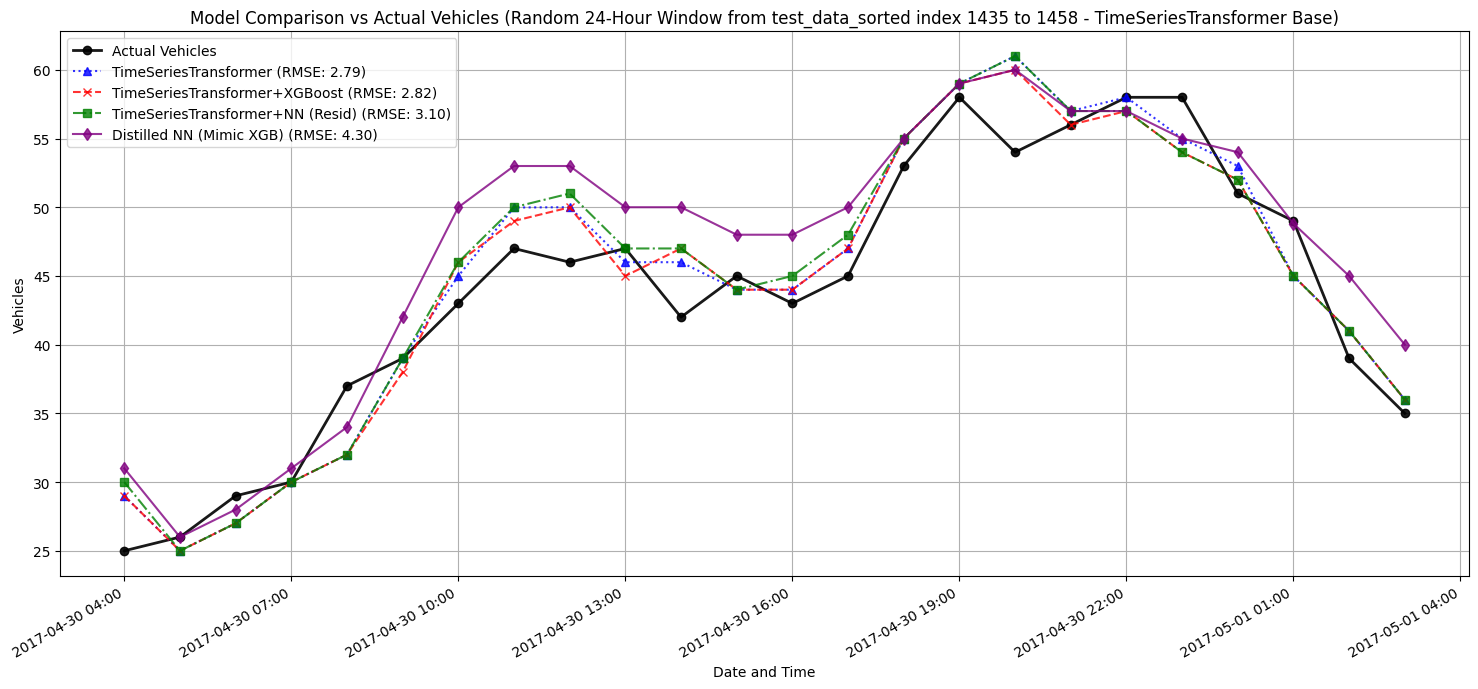

In [ ]:
# === Plot Random 24-Hour Window (TimeSeriesTransformer Base) ===
import random
import matplotlib.dates as mdates # Import for date formatting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas for DataFrame check
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings # Import warnings

print("\n--- Random 24-Hour Window Predictions (TimeSeriesTransformer Base) ---")

# --- Define context_length used in TimeSeriesTransformer preparation ---
# This value MUST match the one used in TimeSeriesTransformer data preparation cell (e.g., fa036375)
context_length = 168 # This is context_length for TimeSeriesTransformer

# --- Check for necessary variables ---
required_vars_plot = [
    'y_test_orig_final',         # Aligned actual test values from cell 329c3a08
    'timeseriestransformer_test_pred_orig', # Base TimeSeriesTransformer model predictions from cell 7015365d
    'final_test_pred_xgb',         # TimeSeriesTransformer + XGBoost predictions from cell 329c3a08
    'final_test_pred_nn',          # TimeSeriesTransformer + NN (Residual) predictions from cell 85ffd131
    'distilled_nn_test_pred_orig', # Distilled NN (Mimic XGB) predictions from cell 105334e4
    'test_data_sorted',          # DataFrame with original DateTime from cell fa036375
    'lags_sequence'              # Lags sequence from TimeSeriesTransformer data prep (cell fa036375)
]

# --- Define placeholders for plotting if variables are missing ---
placeholder_value_array = np.array([])
placeholder_df = pd.DataFrame({'DateTime': pd.to_datetime([])}) # Empty DataFrame with DateTime
plot_possible = True

missing_vars_details = {}
for var in required_vars_plot:
    if var not in globals():
        missing_vars_details[var] = f"Missing: '{var}'"
        plot_possible = False # Cannot plot reliably if key components are missing
        if 'pred_orig' in var or 'orig_final' in var:
            globals()[var] = placeholder_value_array
        elif 'test_data_sorted' in var:
            globals()[var] = placeholder_df
        elif 'lags_sequence' in var:
            globals()[var] = [] # Placeholder for lags_sequence

if missing_vars_details:
    print("Error: Missing variables required for plotting:")
    for var, msg in missing_vars_details.items():
        print(f"  - {msg}")
    print("Ensure previous evaluation cells for all models (TimeSeriesTransformer, XGBoost, NN, Distilled NN) and TimeSeriesTransformer data preparation ran successfully.")

# Further checks only if initial check passed and essential data exists
if plot_possible:
    if not isinstance(globals()['test_data_sorted'], pd.DataFrame) or 'DateTime' not in globals()['test_data_sorted'].columns:
        print("Error: 'test_data_sorted' is not a DataFrame or is missing the 'DateTime' column.")
        plot_possible = False
    elif not isinstance(globals()['lags_sequence'], list):
        print("Error: 'lags_sequence' is not a list.")
        plot_possible = False
    elif globals()['y_test_orig_final'].size == 0:
        print("Error: 'y_test_orig_final' is empty. Cannot proceed with plotting.")
        plot_possible = False

if plot_possible:
    current_y_test_orig_final = globals()['y_test_orig_final']
    current_test_data_sorted = globals()['test_data_sorted']
    current_lags_sequence = globals()['lags_sequence']

    # Calculate the correct offset for DateTime alignment
    max_l = max(current_lags_sequence) if current_lags_sequence else 0
    # This is timeseriestransformer_encoder_seq_len: the number of initial data points in test_data_sorted
    # that are used as history/lags before the first prediction can be made.
    # For TimeSeriesTransformer, past_values fed to encoder is context_length + max_lag
    datetime_start_offset = context_length + max_l

    # Check if test_data_sorted is long enough for this offset
    if len(current_test_data_sorted) < datetime_start_offset + len(current_y_test_orig_final):
        print(f"Error: 'test_data_sorted' (len: {len(current_test_data_sorted)}) is not long enough for the calculated datetime_start_offset ({datetime_start_offset}) and length of 'y_test_orig_final' ({len(current_y_test_orig_final)}).")
        plot_possible = False
    else:
        # Create aligned DateTime array
        # The predictions in y_test_orig_final correspond to datetimes starting from this offset
        aligned_datetimes = current_test_data_sorted['DateTime'].iloc[datetime_start_offset : datetime_start_offset + len(current_y_test_orig_final)]

        if len(aligned_datetimes) != len(current_y_test_orig_final):
            print(f"Error: Failed to create aligned DateTime array. Expected length {len(current_y_test_orig_final)}, got {len(aligned_datetimes)}.")
            plot_possible = False
        else:
            # Check lengths of all prediction arrays against y_test_orig_final
            mismatched_lengths_detail = []
            for var_name in ['timeseriestransformer_test_pred_orig', 'final_test_pred_xgb', 'final_test_pred_nn', 'distilled_nn_test_pred_orig']:
                pred_array = globals().get(var_name, placeholder_value_array) # Uses placeholder if var missing
                if len(pred_array) != len(current_y_test_orig_final):
                    mismatched_lengths_detail.append(f"{var_name} (len: {len(pred_array)})")

            if mismatched_lengths_detail:
                print(f"Warning: Length mismatch found against 'y_test_orig_final' (len: {len(current_y_test_orig_final)}):")
                for detail in mismatched_lengths_detail:
                    print(f"  - {detail}")
                print("Plotting will proceed, but mismatched series will be skipped.")
                # We don't set plot_possible = False here, the plotting loop will handle skipping.


# --- Attempt Plotting if Possible ---
if plot_possible:
    window_size = 24
    # Ensure we don't select a start index too close to the end *of the aligned data*
    max_start_index = len(current_y_test_orig_final) - window_size
    if max_start_index < 0:
        print(f"Error: Aligned test set length ({len(current_y_test_orig_final)}) is smaller than the window size ({window_size}). Cannot plot window.")
    else:
        random_start_index = random.randint(0, max_start_index)
        end_index = random_start_index + window_size
        window_indices = range(random_start_index, end_index)

        print(f"Selected random window (indices within aligned data): {random_start_index} to {end_index-1}")

        window_actual = current_y_test_orig_final[window_indices]
        window_datetimes = aligned_datetimes.iloc[window_indices]

        # Get prediction data for the window, using placeholders if variables were missing
        window_timeseriestransformer = globals().get('timeseriestransformer_test_pred_orig', placeholder_value_array)
        if len(window_timeseriestransformer) == len(current_y_test_orig_final): window_timeseriestransformer = window_timeseriestransformer[window_indices]
        else: window_timeseriestransformer = placeholder_value_array # Ensure it's empty if length was wrong

        window_xgb = globals().get('final_test_pred_xgb', placeholder_value_array)
        if len(window_xgb) == len(current_y_test_orig_final): window_xgb = window_xgb[window_indices]
        else: window_xgb = placeholder_value_array

        window_nn_resid = globals().get('final_test_pred_nn', placeholder_value_array)
        if len(window_nn_resid) == len(current_y_test_orig_final): window_nn_resid = window_nn_resid[window_indices]
        else: window_nn_resid = placeholder_value_array

        window_distilled_nn = globals().get('distilled_nn_test_pred_orig', placeholder_value_array)
        if len(window_distilled_nn) == len(current_y_test_orig_final): window_distilled_nn = window_distilled_nn[window_indices]
        else: window_distilled_nn = placeholder_value_array

        def calculate_window_metrics(actual, pred):
            if isinstance(pred, np.ndarray) and len(actual) == len(pred) and len(actual) > 0:
                rmse = np.sqrt(mean_squared_error(actual, pred))
                mae = mean_absolute_error(actual, pred)
                return rmse, mae
            return np.nan, np.nan

        timeseriestransformer_rmse_window, timeseriestransformer_mae_window = calculate_window_metrics(window_actual, window_timeseriestransformer)
        xgb_rmse_window, xgb_mae_window = calculate_window_metrics(window_actual, window_xgb)
        nn_resid_rmse_window, nn_resid_mae_window = calculate_window_metrics(window_actual, window_nn_resid)
        distilled_nn_rmse_window, distilled_nn_mae_window = calculate_window_metrics(window_actual, window_distilled_nn)

        print(f"TimeSeriesTransformer Random Window RMSE: {timeseriestransformer_rmse_window:.2f}, MAE: {timeseriestransformer_mae_window:.2f}")
        print(f"TimeSeriesTransformer+XGBoost Random Window RMSE: {xgb_rmse_window:.2f}, MAE: {xgb_mae_window:.2f}")
        print(f"TimeSeriesTransformer+NN (Resid) Random Window RMSE: {nn_resid_rmse_window:.2f}, MAE: {nn_resid_mae_window:.2f}")
        print(f"Distilled NN (Mimic XGB) Random Window RMSE: {distilled_nn_rmse_window:.2f}, MAE: {distilled_nn_mae_window:.2f}")

        plt.figure(figsize=(15, 7))
        plt.plot(window_datetimes, window_actual, label='Actual Vehicles', marker='o', linestyle='-', linewidth=2, alpha=0.9, color='black')

        model_data = [
            ('TimeSeriesTransformer', window_timeseriestransformer, timeseriestransformer_rmse_window, timeseriestransformer_mae_window, '^', ':', 'blue'),
            ('TimeSeriesTransformer+XGBoost', window_xgb, xgb_rmse_window, xgb_mae_window, 'x', '--', 'red'),
            ('TimeSeriesTransformer+NN (Resid)', window_nn_resid, nn_resid_rmse_window, nn_resid_mae_window, 's', '-.', 'green'),
            ('Distilled NN (Mimic XGB)', window_distilled_nn, distilled_nn_rmse_window, distilled_nn_mae_window, 'd', '-', 'purple')
        ]

        for name, pred, rmse, mae, marker, linestyle, color in model_data:
            if isinstance(pred, np.ndarray) and len(pred) == len(window_actual) and not np.isnan(rmse) and pred.size > 0: # Added pred.size > 0
                label = f'{name} (RMSE: {rmse:.2f})'
                plt.plot(window_datetimes, pred, label=label, marker=marker, linestyle=linestyle, alpha=0.8, color=color)
            else:
                print(f"Skipping plot for {name} due to missing data, length mismatch, or invalid metrics in window.")

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
        plt.gcf().autofmt_xdate()

        # Corrected original index calculation for the title
        original_start_idx_in_test_data_sorted = random_start_index + datetime_start_offset
        original_end_idx_in_test_data_sorted = end_index + datetime_start_offset -1 # -1 because end_index is exclusive

        plt.title(f'Model Comparison vs Actual Vehicles (Random 24-Hour Window from test_data_sorted index {original_start_idx_in_test_data_sorted} to {original_end_idx_in_test_data_sorted} - TimeSeriesTransformer Base)')
        plt.xlabel('Date and Time')
        plt.ylabel('Vehicles')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("\nSkipping random window plot due to missing critical variables, empty target data, or fundamental alignment issues.")